In [19]:
import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
import glob
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND 
from rnn.model import Attention
import matplotlib.pyplot as plt
np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'ignore', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [20]:
def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.nanmean(losses)

def evaluate(model, ldr, preproc, store_prediction=False, print_prediction=False):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    if store_prediction:
        with open("test_results.json", "w") as res:
            json.dump(results, res)

    if print_prediction:
        for (truth, pred) in results:
            print('True label:\n  ', end="")
            for char in truth:
                print(char, end=" ")
            print('\nPredicted labal:\n  ', end="")
            for char in pred:
                print(char, end=" ")
            print('')

    return np.nanmean(losses), compute_wer(results)

In [21]:
#Loading

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

data_cfg = config["data"]
opt_cfg = config["optimizer"]

start = time.time()
preproc = Preprocessor(data_cfg["all_data"], start_and_end=data_cfg["start_and_end"])
print("Preprocessing finished", time.time() - start, "seconds elapsed")

start = time.time()
train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
print("Train Loaded", time.time() - start, "seconds elapsed")   

start = time.time()    
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])
print("Dev Loaded", time.time() - start, "seconds elapsed")

start = time.time()
test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])
print("Test Loaded", time.time() - start, "seconds elapsed")

Preprocessing finished 22.143883228302002 seconds elapsed
Train Loaded 2059.662060022354 seconds elapsed
Dev Loaded 283.79179430007935 seconds elapsed
Test Loaded 576.9435803890228 seconds elapsed


In [23]:
#Training
# Reload config if changed epoch
with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)
model_cfg = config["model"]
opt_cfg = config["optimizer"]
print("max epochs:", opt_cfg["max_epochs"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
print("------------")

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"], 512)
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])
#change this
mslst = [int(y) for y in [50 * (2 ** x) for x in range(20)] if y < opt_cfg["max_epochs"]]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=mslst, gamma=0.1)

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"
losses = []
weres = []


best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    scheduler.step()

    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)    
    losses.append(dev_loss)
    weres.append(dev_wer)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    for param_group in optimizer.param_groups:
        print('...learning rate: ' + str(param_group['lr']))

    torch.save(model, os.path.join(config["save_path"], str(ep)))   
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))

max epochs: 100
Training RNN
------------
epoch    1 | train_loss=233.07, dev_loss=242.27 with  95.79% WER (191.78s elapsed)
...learning rate: 0.1
epoch    2 | train_loss=222.69, dev_loss=227.29 with  97.06% WER (194.87s elapsed)
...learning rate: 0.1
epoch    3 | train_loss=216.90, dev_loss=175.50 with 102.76% WER (201.05s elapsed)
...learning rate: 0.1
epoch    4 | train_loss=213.75, dev_loss=167.01 with 611.23% WER (220.88s elapsed)
...learning rate: 0.1
epoch    5 | train_loss=209.24, dev_loss=159.67 with  96.15% WER (194.26s elapsed)
...learning rate: 0.1
epoch    6 | train_loss=207.31, dev_loss=151.17 with 611.42% WER (220.69s elapsed)
...learning rate: 0.1
epoch    7 | train_loss=205.39, dev_loss=142.27 with 611.46% WER (220.65s elapsed)
...learning rate: 0.1
epoch    8 | train_loss=203.38, dev_loss=138.49 with  95.60% WER (193.22s elapsed)
...learning rate: 0.1
epoch    9 | train_loss=200.96, dev_loss=133.63 with 611.07% WER (220.79s elapsed)
...learning rate: 0.1
epoch   10 | 

epoch   75 | train_loss= 90.16, dev_loss= 26.70 with 105.07% WER (200.69s elapsed)
...learning rate: 0.010000000000000002
epoch   76 | train_loss= 86.60, dev_loss= 26.13 with 106.55% WER (200.69s elapsed)
...learning rate: 0.010000000000000002
epoch   77 | train_loss= 91.00, dev_loss= 26.43 with 105.66% WER (199.57s elapsed)
...learning rate: 0.010000000000000002
epoch   78 | train_loss= 87.94, dev_loss= 26.44 with 105.50% WER (199.37s elapsed)
...learning rate: 0.010000000000000002
epoch   79 | train_loss= 86.68, dev_loss= 26.32 with 105.71% WER (200.74s elapsed)
...learning rate: 0.010000000000000002
epoch   80 | train_loss= 86.85, dev_loss= 26.00 with 105.10% WER (200.67s elapsed)
...learning rate: 0.010000000000000002
epoch   81 | train_loss= 82.25, dev_loss= 26.20 with 106.57% WER (200.89s elapsed)
...learning rate: 0.010000000000000002
epoch   82 | train_loss= 88.68, dev_loss= 26.57 with 105.92% WER (200.11s elapsed)
...learning rate: 0.010000000000000002
epoch   83 | train_loss=

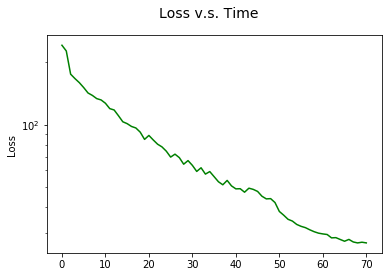

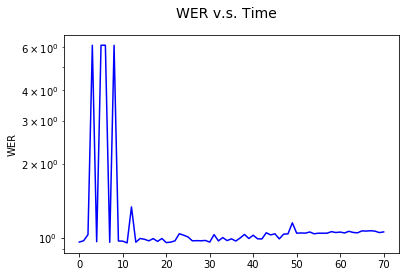

In [26]:
eps = list(range(opt_cfg["max_epochs"]))
'''
fig, ax1 = plt.subplots()
plt.suptitle("Loss & WER v.s. Time", fontsize=14)
ax2 = ax1.twinx()
ax1.plot(eps[:61], losses[:61], 'green')
ax2.plot(eps[:61], weres[:61], 'blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='green')
ax2.set_ylabel('WER', color='blue')
'''
plt.suptitle("Loss v.s. Time", fontsize = 14)
plt.plot(eps[:71], losses[:71], 'green')
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

plt.suptitle("WER v.s. Time", fontsize = 14)
plt.plot(eps[:71], weres[:71], 'blue')
plt.ylabel("WER")
plt.yscale("log")
plt.show()

In [25]:
#Testing

print("Testing RNN")
print("-------------")

test_model = torch.load(os.path.join(config["save_path"], "80"))
_, test_wer = evaluate(test_model, test_ldr, preproc, store_prediction=True, print_prediction=True)

print("{:.2f}% WER (test)".format(test_wer * 100.))

Testing RNN
-------------


D:\TTIC-31110-Final-Project\rnn\model.py:181: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  x, h = self.enc_rnn(x)
D:\TTIC-31110-Final-Project\rnn\model.py:210: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  ox, hx = self.dec_rnn(ix, hx=hx)
D:\TTIC-31110-Final-Project\rnn\model.py:232: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  ox, hx = self.dec_rnn(ix, hx=hx)


True label:
  xiao3 fang2 zi5 de5 men2 bi4 zhe5 chuang1 shang5 men2 shang4 dou1 cheng1 zhe5 ya2 bai2 de5 lian2 er2 bing4 mei2 you3 hua1 ying3 yin1 wei4 yang2 guang1 bu4 zu2 
Predicted labal:
  jie2 guo3 dai4 shang4 he4 ran2 chang3 ran2 jia1 yu4 zhe5 jing1 ye4 shi4 de5 ye4 he2 jia1 yang2 zhe5 cu1 hao2 chen2 ya3 de5 hua4 yu3 ru2 zou3 ru4 tong2 hua4 jing4 jie4 
True label:
  you3 wei4 ting3 you3 ming2 de5 zuo4 jia1 shuo1 xiao3 shi2 hou5 mei4 mei5 e4 de5 ku1 wai4 mian4 tu1 ran2 chuan2 lai2 shu3 a5 shu3 a5 de5 jiao4 mai4 sheng1 na4 shi4 mai4 bai2 shu3 de5 lai2 le5 
Predicted labal:
  ta1 hua2 she4 bo1 en1 yi1 yue4 san1 ri4 xiao1 xi5 xi1 de2 ren2 lei4 xue2 jia1 jing1 kao2 gu3 fa1 xian4 yuan3 zai4 shi2 qi4 shi2 dai4 de5 ren2 jiu4 huan4 you3 ai2 zheng4 
True label:
  yun4 dong4 yuan2 cun1 bi4 xu1 yong4 tie3 lan2 gan5 wei2 qi3 lai5 you3 wu3 zhuang1 jing3 wei4 zhan4 gang3 yi3 bao3 zheng4 yun4 dong4 yuan2 jue2 dui4 an1 quan2 
Predicted labal:
  zhe4 hua2 she4 nan2 ning2 yi1 yue4 shi2 ri4 dian4 ke

  ta1 gu3 tou5 liu4 lian2 li4 ren4 zhu2 guan3 zhan4 dou4 ying1 xiong2 he2 zhuan3 ye4 tui4 wu3 gan4 bu5 zhan4 shi4 dai4 biao3 ying4 yao1 zuo4 zai4 jia1 bin1 xi2 shang4 
True label:
  fan3 zheng4 zan2 gao1 di1 dou1 bu4 shuo1 sha2 zuo4 ren2 bu4 neng2 wang4 ben3 mei2 you3 lao2 ma3 na3 er5 you3 yun2 xia2 de5 jin1 tian1 wo3 sha2 ye3 bu4 shuo1 la5 
Predicted labal:
  zai4 ci4 yuan4 mei2 dao4 tong2 xue2 jia1 qu4 wu3 tai4 tai5 jiao4 ta1 shun4 bian4 wan1 dao4 xun2 jia1 qu4 song4 ge4 xin4 ye3 shi4 mian3 de5 rang4 xun2 tai4 tai5 you4 gei3 jiu3 qian2 
True label:
  jin1 ji1 shan1 xia4 de5 nong4 yao2 cun1 ai4 kou3 zhen4 guo4 qu4 qiong2 de5 ding1 dang1 xiang3 xian4 zai4 que4 chu1 le5 bai3 wan4 fu4 weng1 shen4 zhi4 qian1 wan4 fu4 weng1 
Predicted labal:
  ta1 men5 you4 nian2 kai1 shi3 ji2 shou4 dao4 yin1 yue4 xun1 tao2 liu4 sui4 ji2 jie1 shou4 yin1 yue4 jiao4 yu5 ceng2 sui2 fu4 xue2 xi2 da4 ti2 qin2 
True label:
  ma3 xiao3 nian2 zuo4 hua4 de5 te4 zheng1 yu3 shen2 yun4 qi2 hua4 feng1 qu1 bie2 yu2 wen2

  ta1 men5 you3 you3 wei4 ren2 yuan2 le5 xiang1 gang3 wang1 fu1 fu4 lia3 yu3 chen2 gong1 bo2 deng3 dou1 shi4 guang3 dong1 ren2 you3 ge4 fu4 guan1 yu3 kuang4 yu4 min2 shi4 xiao3 tong2 xiang1 
True label:
  huan4 ju4 hua4 shuo1 yi2 ge4 lv4 yuan2 zi3 zhi3 neng2 he2 yi2 ge4 na4 yuan2 zi3 jie2 he2 er2 er4 ge4 lv4 yuan2 zi3 cai2 neng2 he2 yi2 ge4 mei3 yuan2 zi3 hua4 he2 
Predicted labal:
  zai4 zhi1 zai4 a1 gen1 ting2 zu2 tan2 ben3 lai2 zhan4 ji4 bu2 suan4 hen3 tu1 chu1 de5 ju4 le4 bu4 dui4 kua4 yang2 zheng1 duo2 zhou1 ji4 bei1 yin2 qi3 yu2 lun4 de5 guan1 zhu4 
True label:
  lv3 yu3 you2 de5 shi2 jian1 bi3 wang3 wang3 lv2 chang2 you2 duan3 yu3 you2 ke4 de5 yuan4 wang5 xiang1 bei4 
Predicted labal:
  ta1 wai4 de5 de5 de5 wen2 ming2 gun4 zhe4 li3 cha1 yi2 xia4 na4 li3 tong3 yi2 xia4 yi4 xie1 po4 bu4 lan4 pian4 gei3 ta1 de5 wen2 ming2 gun4 fan1 de5 luan4 qi1 ba1 zao1 
True label:
  nan2 bin1 yi2 ge4 zao3 shi2 wu3 yuan2 nv3 bin1 shi2 yuan2 chu2 le5 chi2 lin2 pen2 yu4 yi3 wai4 tong2 yang4 ke3 xia

  zai4 guo2 de5 yi4 de5 jin4 kuai4 bai2 chou2 pa4 zi5 bao1 le5 jin1 huang2 tuo3 yuan2 de5 pi2 pa5 yong4 yi2 ge4 zhi3 tou5 gou1 zhe5 yan3 zhu1 zi5 rou2 rou5 di4 wang4 ta1 
True label:
  pan2 wan3 de5 nei4 bu4 huo4 wai4 bu4 bu4 fen5 yin4 you3 qing1 hua1 tu2 an4 he2 kuan3 ji4 can2 pan2 di3 nei4 yin4 you3 fo2 shou3 chan2 zhi1 hua1 wen2 tu2 an4 
Predicted labal:
  ta1 men5 ta1 zhe4 zhong3 zhuang4 kuang4 gai4 kuo4 wei2 jing3 yue4 da3 yue4 shen1 beng4 yue4 huan4 yue4 da4 qian2 yue4 hua1 yue4 duo1 shui3 yue4 chou1 yue4 shao3 
True label:
  si4 shi4 dui4 quan2 ti3 yuan2 gong1 jia1 qiang2 wai4 yu3 pei2 xun4 yan2 ge2 wai4 yu3 kao3 shi4 bing4 ba3 wai4 yu3 cheng2 ji4 he2 ben3 ren2 de5 jing1 ji4 shou1 ru4 gua4 gou1 
Predicted labal:
  ta1 men5 zhong1 yi1 zhong1 yi1 yue4 shi2 ri4 xiao1 xi5 xi1 de2 ren2 lei4 xue2 jia1 jing1 kao2 gu3 fa1 xian4 yuan3 zai4 shi2 qi4 shi2 dai4 de5 ren2 jiu4 huan4 you3 ai2 zheng4 
True label:
  nan2 jing1 xuan2 wu3 hu2 dong4 wu5 yuan2 li3 de5 yi2 dui4 hong2 xing1 xing5 xue2

  ta1 shi4 er4 er4 shi2 er4 ri4 xin1 shi4 te4 yao1 qing3 ying1 shi4 de5 gong1 si1 jin1 shi2 shi4 xin1 ling4 ren2 si1 tuo1 yan2 si1 lu4 de5 si1 lu4 hui4 jie1 bing4 
True label:
  qin2 hua2 sun1 zhi3 chu1 wei4 le5 shi2 xian4 yin4 du4 yang2 he2 ping2 qu1 de5 mu4 biao1 xu1 yao4 qu1 yu4 nei4 bu4 he2 wai4 bu4 guo2 jia1 de5 gong4 tong2 nu3 li4 
Predicted labal:
  qu4 nian2 shi2 yi1 yue4 mo4 e2 lian2 bang1 xian4 fa3 fa3 fa3 yuan4 xuan1 bu4 jie3 san4 e2 gong4 ji1 ceng2 zu3 zhi1 wei2 fan3 xian4 fa3 
True label:
  yi1 sheng1 wen4 ta1 na3 er5 bu4 shu1 fu5 ta1 shuo1 hou2 long5 bei4 yu2 ci4 qia3 zhu4 le5 he1 cu4 tun1 fan4 tuan2 yong4 shou3 wa1 dou1 mei2 you3 yong4 
Predicted labal:
  zai4 shi4 dui4 dang1 shi2 de5 dao4 xue2 pai4 zhu3 zhang1 nan2 nv3 hun1 yin1 zi4 zhu3 ceng2 bei4 ren2 wu1 mie4 you3 xia2 ji4 nv3 bai2 zhou4 tong2 yu4 gou1 yin3 shi4 
True label:
  wei4 jin1 nian2 yang1 tian2 chu2 bai4 you3 shen2 me5 hao3 yao4 yi1 wei4 ye4 xia4 jia2 gen1 yan1 tong5 gan3 de5 lao3 nong2 qiang3 xian1 wen4 da

  wo3 de2 de5 yue4 shao3 dui4 lian2 meng2 yue4 you3 hao3 chu4 yin1 wei4 ta1 men5 ren4 wei2 wo3 huo4 xu3 hui4 gei3 xin1 jin4 qiu2 yuan2 kai1 xia4 e4 li4 
Predicted labal:
  ta1 men5 bu4 jiu3 jiu3 liu4 nian2 liu4 er4 shi2 si4 yun4 dong4 yuan2 you3 yun4 dong4 yuan2 deng3 si4 qian1 duo1 tou2 
True label:
  tan1 wu1 nuo2 yong4 juan1 zeng4 zhen4 zai1 kuan3 wu4 shi4 chu4 fan4 fa3 lv4 xing2 wei2 yao4 an4 zhao4 xing2 fa3 di4 yi4 bai3 er4 shi2 liu4 tiao2 gui1 ding4 yan2 su4 chu2 li3 
Predicted labal:
  hong2 ye4 bo1 de5 ding4 you1 yue4 se4 zhong1 bian4 bo1 yu2 wei2 ji1 yi4 yi4 shu4 yi3 wu4 shou4 hui4 xu1 lv4 jiao1 yi4 wu4 
True label:
  feng1 lei2 jiao1 jia1 de5 yan2 han2 li3 wo3 jun1 ying1 yong3 pin1 sha1 you3 si4 ge4 ying2 gong1 ru4 bao1 tou2 cheng2 nei4 tong2 di2 jun1 zhan3 kai1 bai2 ren4 xiang4 zhan4 
Predicted labal:
  ta1 shu1 zhong4 dian3 jie4 shao4 le5 qi3 ye4 chou2 zi1 yu3 fu4 zhai4 jing1 ying2 zhui1 tao3 zhai4 wu4 fa1 sheng1 ji1 zhi4 ji2 mao4 shi4 
True label:
  jie2 zhi4 jin1 nian2 wu

  mei3 rong2 pin3 jian3 fei2 yao4 ying2 yang3 ye4 shi4 chang3 zou3 qiao4 you3 ren2 ren4 wei2 shi4 kao4 guang3 gao4 ying4 shan1 huo2 qi3 lai2 de5 
Predicted labal:
  ta1 hua2 she4 tai4 yuan2 er4 yue4 wu3 ri4 dian4 ke1 xue2 jia1 yan2 jiu1 fa1 xian4 zhang3 wo4 ying4 yong4 qi4 xiang4 zi1 liao4 neng2 gou4 yu4 fang2 mei2 kuang4 de5 wa3 si1 bao4 zha4 
True label:
  cheng2 ran2 bing4 fei1 suo2 you3 wu3 tuan2 dou1 xiang4 ba1 lei2 wu3 tuan2 na4 yang4 xing4 yun4 ba1 lei2 wu3 tuan2 ye3 bing4 fei1 suo2 you3 ju4 mu4 dou1 shou4 huan1 ying2 
Predicted labal:
  ta1 wai4 chou4 ming2 zhao1 zhu4 de5 ri4 ben3 nv3 jian4 die2 chuan1 dao3 fang1 zi3 ye3 zai4 zhe4 li3 tong2 meng2 gu3 wang2 ye5 zhi1 zi3 ju3 xing2 guo4 hun1 li3 
True label:
  ji3 chu4 ao4 kou3 bei4 zhan4 huo3 ran2 shao1 guo4 qing1 yan1 yi1 ran2 piao1 niao3 er2 sheng1 chao2 he2 gu3 shang4 kong1 mi2 san4 zhi2 dao4 yu3 tian1 di4 rong2 wei2 yi4 ti3 
Predicted labal:
  ta1 dao4 jia1 huang2 niang2 niang5 de5 nai3 wa2 er5 zheng4 ku1 de5 si1 sheng1 ya3 q

  wo3 jiu4 zhe4 yang4 you2 zhu4 yi4 shou3 bi4 tui1 shui3 shi2 bie2 tai4 meng3 liang2 tui3 hou4 deng1 shi2 ye3 yao4 yong4 jin4 jun1 yun2 ni3 zong3 xi3 huan1 yong4 li4 guo4 meng3 
Predicted labal:
  zhe4 xie1 yi2 zai4 yin1 qing2 qing2 ju4 tuan2 tai2 shang4 wei4 kuang4 gong1 ren4 shan1 qu1 mei2 zhe4 li3 sheng1 huo2 de5 de5 gei3 ta1 le5 
True label:
  shui4 wu4 ji1 guan1 an4 gui1 ding4 yi1 ju4 cun2 gen1 lian2 shou1 shui4 zi4 ran2 bei4 yao2 chang3 zuan1 le5 kong4 zi5 yao2 chang3 yi2 ci3 tou1 shui4 wu3 wan4 yuan2 
Predicted labal:
  zhe4 ci4 di4 er4 shi2 yao1 qiu2 luo2 ma2 li3 ao4 mei3 yue4 xiang4 ta1 zhi1 fu4 wu3 wan4 wu3 qian1 wu2 bai3 wu3 shi2 wu3 mei3 yuan2 de5 sheng1 huo2 fei4 yong4 
True label:
  da4 gai4 dai4 zhi4 ming2 qing1 zhi1 ji4 yue4 bing5 cai2 yue4 zhi4 yue4 jing1 chi1 yue4 bing5 zhi1 feng1 ye3 jiu4 zhu2 jian4 sheng4 xing2 qi3 lai5 
Predicted labal:
  zhe4 hua2 she4 tai4 yuan2 er4 yue4 wu3 ye4 dian4 ke1 xue2 jia1 yan2 jiu1 fa1 xian4 zhang3 wo4 ying4 yong4 qi4 xiang4 zi1 liao4 n

  ta1 zou3 dao4 wu1 jiao3 lian3 pen2 jia4 pang2 ba3 lian3 pen2 kuang1 lang1 yi4 sheng1 reng1 zai4 yi1 luo4 lian3 pen2 shang4 
Predicted labal:
  zhe4 men5 de5 de5 de5 de5 de5 jia1 de5 de5 you3 de5 de5 de5 de5 de5 de5 de5 de5 yi4 de5 de5 yi4 de5 
True label:
  guo2 wu4 yuan4 chu1 yu2 an1 quan2 kao3 lv4 mei2 you3 tou4 lu4 shui2 jiang1 qian2 wang3 ka1 bu4 er3 ye3 bu2 tou4 lu4 zhe4 wei4 wai4 jiao1 guan1 jiang1 cong2 he2 di4 chu1 fa1 
Predicted labal:
  wo3 ceng2 yu4 dao4 zhi1 wei3 wang2 xian4 ben3 ting1 shuo1 lin2 jin4 he2 zhuang1 cun1 you3 ren2 yong4 da4 peng2 pei2 yu4 suan4 huang2 cheng2 gong1 jiu4 qu4 cai2 fang3 
True label:
  han2 dian4 wei4 yu2 xi1 bei3 dian4 wang3 mo4 duan1 qi2 an1 quan2 sheng1 chan3 dui4 gai1 dian4 wang3 wen3 ding4 yun4 xing2 you3 zhong4 yao4 yi4 yi5 
Predicted labal:
  xin1 hua2 she4 kun1 ming2 er4 yue4 shi2 ri4 dian4 ke1 xue2 jia1 yan2 jiu1 fa1 xian4 zhang3 wo4 ying4 yong4 qi4 xiang4 zi1 liao4 neng2 gou4 yu4 fang2 mei2 kuang4 de5 wa3 si1 bao4 zha4 
True label:
  c

  tai4 yuan2 shi4 yang2 quan2 shi4 shuai4 xian1 ban4 qi3 le5 long2 ya3 er2 you4 er2 yuan2 he2 long2 er2 ting1 li4 yu3 xun4 zhong1 xin1 
Predicted labal:
  ta1 men5 zhong1 de5 cheng1 zan4 xi1 fan4 xian2 cai4 de5 biao1 zhun3 niu2 jin1 wei4 er5 de5 ying1 yu3 lu4 dao4 le5 he2 er2 dai4 shang4 fang4 gei3 shou4 gao1 tiao1 er2 zi5 ting1 
True label:
  ta1 men5 zhua1 lai2 le5 hui2 jia1 wei4 fu4 qin5 song4 sang4 de5 nian2 qing1 yi1 sheng1 su1 yuan2 he2 qi1 zi5 mou2 qing1 bi1 po4 wei4 ta1 men5 zhi4 bing4 
Predicted labal:
  shi2 yue4 shi2 er4 ri4 ri4 jun1 jin4 fan4 ning2 bo1 yu2 bu4 yun2 you4 wen2 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 jiu3 shi2 nian2 ba1 
True label:
  qing1 dai4 xue2 zhe3 cheng1 zhui1 wei2 zhong4 ni2 wen2 wang4 zhi1 long2 ze2 zai4 liu4 ji2 kong2 zi3 yin1 shou3 kai1 si1 xue2 zheng3 xiu1 gu3 ji2 shou1 tu2 jiang3 xue2 er2 cheng2 wan4 shi4 shi1 biao3 
Predicted labal:
  zhe4 zhong3 dian4 re4 bei1 

  gai1 yuan4 te4 pin4 qian2 wei3 chang2 tang2 ke4 wei2 gu4 wen4 nie4 wei4 ping2 wei2 ming2 yu4 yuan4 zhang3 
Predicted labal:
  zhe4 shi4 guo4 jie2 cun1 li3 zu3 zhi1 ge4 zhong3 xing2 shi4 de5 ge1 wu3 hui4 ti3 yu4 bi3 sai4 qing3 ju4 tuan2 fang4 ying4 dui4 lai2 cun1 li3 yan3 chu1 
True label:
  wa2 wa5 yu2 de5 sheng1 huo2 xi2 xing4 te4 shu1 bu2 yi4 ren2 gong1 wei4 yang3 ran2 er2 you2 ke4 que4 bu4 zhi1 zhe4 xie1 zhi3 tu2 xi1 qi2 hao3 wan2 sui2 yi4 bu3 zhuo1 
Predicted labal:
  zhe4 wai4 nian2 zuo4 jia4 ge2 cheng2 ji1 gong1 si1 yu3 nan2 ao4 xian4 ren2 min2 zheng4 fu3 zheng4 shi4 qian1 yue1 lian2 he2 kai1 fa1 yan1 dun1 wan1 wan4 dun1 ji2 shen1 shui2 gang3 
True label:
  zhu3 yao4 yuan2 yin1 shi4 shi4 jie4 hong2 bai2 teng2 zhu2 chan3 guo2 yin4 ni2 jin4 zhi3 hong2 bai2 teng2 yuan2 liao4 chu1 kou3 dao3 zhi4 guo2 ji4 hong2 bai2 teng2 yuan2 liao4 jia4 ge2 shang4 zhang3 
Predicted labal:
  you3 tian1 shang4 shan1 bi3 ao4 tang2 wang3 wang3 wang3 dao4 you3 le5 yu4 you3 yang4 bi3 yue4 jue2 ding4 zuo

  liao2 ning2 jiao4 lian4 guo1 jin1 feng4 dui4 ci3 jie3 shi5 shuo1 wang2 yuan4 zheng4 huan4 gan3 mao4 er2 qu3 yun2 xia2 ze2 you2 yu2 jie2 shi2 bing4 yin1 yi4 zhi2 mei2 lian4 chu1 lai2 
Predicted labal:
  ru2 ci3 ju3 cuo4 yuan2 yu2 hang2 zhou1 wa2 ha1 ha1 shi2 pin3 ji2 tuan2 gong1 si1 zong3 jing1 li3 zong1 qing4 hou4 dui4 shi4 chang3 te4 zhi4 de5 dong4 xi1 
True label:
  dan4 you3 yi2 ge4 qiao2 dun1 wai4 biao3 guang1 jie2 du4 bu2 gou4 ying2 xiang3 qiao2 liang2 wai4 guan1 you3 ren2 ren4 wei2 zhe4 yi1 xiao3 ci1 dian3 wu2 ai4 zhi4 liang4 bu2 bi4 fan3 gong1 
Predicted labal:
  zhe4 shi4 shi4 zheng4 gan3 shang4 xian2 yang2 di4 shi4 ji1 gou4 bian4 hua4 yuan2 xian2 yang2 shi4 gai3 wei2 qin2 du1 qu1 xian2 yang2 di4 qu1 gai3 wei2 xian2 yang2 shi4 
True label:
  bu4 fen1 bie2 he2 suan4 huo4 zhe3 bu4 neng2 zhun3 que4 he2 suan4 de5 qi2 fei1 ying1 shui4 lao2 wu4 ying1 yu3 huo4 wu4 huo4 ying1 shui4 lao2 wu4 yi2 bing4 zheng1 shou1 zeng1 zhi2 shui4 
Predicted labal:
  zhe4 yu2 you3 min2 yin1 yan4 wu4 h

  yi1 wei4 zhuan1 jia1 tan2 dao4 da4 jia1 gan3 xing4 qu5 de5 jian3 fei2 shi2 shuo1 jian3 fei2 wu2 wai4 hu1 chi1 yao4 jian3 fei2 he2 ti3 wai4 jian3 fei2 liang2 zhong3 
Predicted labal:
  ta1 men5 shi2 shi2 wu3 guan1 xi5 chu2 le5 yao4 li3 shun4 zheng4 qi3 guan1 xi5 wai4 shou3 xian1 yao4 li3 shun4 qi3 ye4 zi1 chan3 suo2 you2 zhe3 yu3 jing1 ying2 zhe3 de5 guan1 xi5 
True label:
  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
Predicted labal:
  zai4 shi4 yang2 chun1 nong2 min2 quan2 guo2 lao2 mo2 qin1 wan4 you3 de5 yuan2 yi4 chang3 kan4 dao4 si4 qian1 mu3 gan1 ju2 lin2 zai4 yan4 yang2 xia4 lv4 zhi1 yao2 ye4 xu2 bu4 zhang3 zan4 bu4 jue2 kou3 
True label:
  liao2 ning2 jiao4 lian4 guo1 jin1 feng4 dui4 ci3 jie3 shi5 shuo1 wang2 yuan4 zheng4 huan4 gan3 mao4 er2 qu3 yun2 xia2 ze2 you2 yu2 jie2 shi2 bing4 yin1 yi4 zhi2 mei2 lian4 chu1 lai2 
Predicted labal:
  ta1 shi4 er4

  kai1 fa1 qu1 yi3 hang2 ye4 gui1 hua4 fen1 wei2 gong1 ye4 qu1 shang1 mao4 qu1 lv3 you2 qu1 sheng1 huo2 qu1 he2 gong1 gong4 jian4 zhu4 qu1 
Predicted labal:
  ta1 men5 jia1 ge4 ti3 zhi4 pin2 chang3 ben3 gai1 yong4 wan2 zheng3 de5 xing2 cai2 sheng1 chan3 men2 chuang1 que4 yong4 ban4 jie2 cai2 da3 jie2 cou4 he5 
True label:
  jing1 shi2 yan4 zheng4 ming2 qi2 sha1 jing1 zi3 xiao4 guo3 gao1 yu2 mu4 qian2 guo2 nei4 yi4 ban1 wai4 yong4 bi4 yun4 yao4 er2 qie3 shi3 yong4 qi3 lai5 an1 quan2 fang1 bian4 
Predicted labal:
  ta1 zhong3 dian4 re4 bei1 ke2 yi3 bi4 yong4 ye3 ke2 yi3 li4 yong4 bu2 pa4 yao2 huang4 dian1 bo3 gai4 kou3 you3 mi4 feng1 quan1 gai4 shang5 you3 feng1 ming2 zhuang1 zhi4 
True label:
  zhe4 peng2 you5 ye3 xiang4 tan2 lian4 ai4 yi2 yang4 dei3 jiang3 yuan2 fen4 you3 yuan2 fen4 shi4 bu2 yong4 ke4 yi4 qu4 zhui1 qiu2 de5 
Predicted labal:
  zhe4 lei4 zhen4 tong4 xin1 yao4 yan2 suan1 er4 qing1 ai1 tuo1 fei1 de5 yan2 zhi4 cheng2 gong1 wei4 ren2 lei4 xun2 zhao3 xin1 de5 te4 xiao4 zhen4

  ta1 men5 you4 pai4 yi1 dui4 ren2 deng1 shang4 an4 qu4 wan1 zhe5 gong1 nu3 jian4 tou2 chao2 zhun3 xiao3 chuan2 bu2 rang4 chuan2 li3 de5 ren2 neng2 you3 yi2 ge4 tao2 shang4 an4 qu4 
Predicted labal:
  ta1 shi4 de5 shuo1 yi2 kao3 wei2 ying1 niao3 suo3 han2 shi2 gu4 you4 ming2 wei2 ying1 tao2 han2 tao2 shu3 qiang2 wei1 ke1 zhi2 wu4 
True label:
  yong4 ren2 dan1 wei4 pin4 yong4 wai4 guo2 ren2 cong2 shi4 de5 gang3 wei4 ying1 shi4 you3 te4 shu1 xu1 yao4 guo2 nei4 zan4 que1 shi4 dang4 ren2 xuan3 qie3 bu4 wei2 fan3 guo2 jia1 you3 guan1 gui1 ding4 de5 gang3 wei4 
Predicted labal:
  ta1 men5 de5 de5 yan2 jiu1 jue2 ding4 hai3 xia2 qing2 zhuan1 lan2 yuan2 ding4 san1 yue4 di3 jie2 shu4 xian4 yan2 zhi4 wu3 yue4 san1 shi5 yi1 ri4 te4 ci3 gao4 zhi1 
True label:
  feng2 nian2 guo4 jie2 cun1 li3 zu3 zhi1 ge4 zhong3 xing2 shi4 de5 ge1 wu3 hui4 ti3 yu4 bi3 sai4 qing3 ju4 tuan2 fang4 ying4 dui4 lai2 cun1 li3 yan3 chu1 
Predicted labal:
  zhe4 wai4 you3 min2 yin1 yan4 wu4 hai3 xing1 dao4 shi2 bei4 lei4 ch

  zhe4 wai4 hai2 you3 ma2 la4 wei4 yan2 hai3 xian1 wei4 yan2 wu3 xiang1 yan2 wu3 wei4 yan2 hu2 jiao1 yan2 xiang1 gu1 yan2 deng3 
True label:
  hong2 niang2 zi3 cha1 jin1 zan1 dai4 yin2 hua1 bi3 mu3 dan1 shao2 yao5 sheng4 wu3 bei4 cong2 rong2 chu1 ge2 wan3 ruo4 yun2 mu3 tian1 xian1 
Predicted labal:
  zai4 nian2 si4 min2 si4 si4 bai3 mu3 la4 jiao1 miao2 yin1 lian2 mian2 yin1 yu3 lan4 yang1 sun3 shi1 san1 wan4 yuan2 yong4 yao4 bao3 hu4 jin4 liu4 qian1 ming2 miao2 zu2 tong2 bao1 
True label:
  lv4 shi4 yang2 chun1 yan1 jing3 da4 kuai4 wen2 zhang1 de5 di3 se4 si4 yue4 de5 lin2 luan2 geng4 shi4 lv4 de5 xian1 huo2 xiu4 mei4 shi1 yi4 ang4 ran2 
Predicted labal:
  ta1 hua2 shi4 de5 yin1 de5 yue4 shi2 xian4 jiang4 you2 kuai4 wan2 le5 na4 tian1 wu3 fan4 hou4 bian4 jiao4 xiao3 ai4 yun2 da3 jiang4 you2 sheng1 you2 ye3 yao4 mai3 le5 
True label:
  ta1 jin3 ping2 yao1 bu4 de5 li4 liang4 zai4 yong3 dao4 shang4 xia4 fan1 teng2 yong3 dong4 she2 xing2 zhuang4 ru2 hai3 tun2 yi4 zhi2 yi3 yi4 tou2 de5 you1

  ling4 wai4 zai4 yong4 cao3 suan1 xi3 mo4 shui3 ji4 hou4 yao4 duo1 yong4 qing1 shui2 xi3 ji3 bian4 bu2 rang4 duo1 yu2 de5 cao3 suan1 liu2 zai4 yi1 fu5 shang4 
Predicted labal:
  ke3 shi4 de5 chang2 you3 ren2 gao4 su5 yao2 xian1 sheng5 shuo1 kan4 jian4 er4 xiao2 jie3 zai4 ka1 fei1 guan2 li3 he2 wang2 jun4 ye4 wo4 zhuo2 shou3 yi2 zuo4 zuo4 shang5 ji3 ge4 zhong1 tou2 
True label:
  yi3 li4 yi4 qian1 qi1 ba1 bai3 nian2 jin1 tian1 reng2 ran2 cang1 yu4 cong1 long2 cha2 ya1 qiu2 qu3 wei4 wei4 ran2 ru2 qun2 long2 shang4 teng2 zhi1 zhuang4 
Predicted labal:
  zai4 wai4 yong1 you3 si4 dun1 wai4 biao3 guang1 jie2 du4 bu2 gou4 ying2 xiang3 qiao2 liang2 wai4 guan1 you3 ren2 ren4 wei2 zhe4 yi1 xiao3 ci1 dian3 wu2 ai4 zhi4 liang4 bu2 bi4 fan3 gong1 
True label:
  jian1 guan3 qu1 yu4 wei2 da4 yao2 wan1 gang3 qu1 da4 lian2 xin1 gang3 gang3 qu1 da4 lian2 jin1 zhou1 qu1 jin1 shi2 tan1 guo2 jia1 lv3 you2 du4 jia4 qu1 
Predicted labal:
  ta1 men5 shi2 de5 shi2 si4 dian3 zhong1 pei2 de2 zhi4 dao4 da4 hai3 

  xiang1 chuan2 sui2 yang2 di4 nan2 xia4 yang2 zhou1 kan4 qiong2 hua1 tu2 jing1 huai2 yin1 shi2 wen2 de2 huai2 yin1 pao2 chu2 shan4 chang2 shao1 yu2 nai3 tu1 fa1 qi2 xiang3 
Predicted labal:
  ta1 shi4 de5 de5 shi2 er4 yue4 shi2 er4 ri4 dian4 wo3 guo2 zhu4 ming2 zhe2 xue2 jia1 ai4 si1 qi2 de5 yi4 pi1 yi2 wu4 zui4 jin4 cong2 bei3 jing1 song4 wang3 yun2 nan2 teng2 chong1 
True label:
  zai4 shi4 chang3 pi2 ruan3 de5 qing2 kuang4 xia4 zhe4 ge5 cheng2 ji4 lai2 zhi1 bu2 yi4 a5 shuo1 qi3 lai2 yu3 gai1 chang3 chi4 hei1 yue1 ri4 chang2 zhang3 de5 da4 peng2 che1 you3 guan1 
Predicted labal:
  ta1 ci4 xia4 wang2 wei4 hou4 hai2 yao4 bei4 zhong4 hou2 tui1 xia4 nu4 jiang1 yan1 si3 suo2 yi3 jiao4 zang4 wang2 tan1 
True label:
  wei4 xi1 yin3 you2 yong3 ai4 hao4 zhe3 ta1 men5 fa1 shou4 nian2 ka3 yue4 ka3 qing2 lv2 ka3 he2 jia1 huan1 ka3 jin1 ka3 
Predicted labal:
  ta1 shi4 you3 sheng1 yin1 you3 yu4 gun3 yu4 da4 yu4 da4 yu4 gun3 gou4 zhu4 cheng2 le5 guang1 yao4 xian3 he4 de5 qun2 feng1 
True label:
 

  zhe4 zhong3 yi4 xie1 kou3 bu2 jian4 wang3 ri4 shai4 tai4 yang5 lao4 ke1 de5 ren2 dui1 tui1 men2 jin4 she4 bu4 wen2 chou2 bei4 guo4 nian2 de5 chui1 yan1 fan4 xiang1 
True label:
  wo3 ai4 hua1 ai4 zi4 ran2 jie4 de5 hua1 geng4 ai4 yong4 ge4 zhong3 wen2 yi4 xing2 shi4 su4 zao4 pei2 yu4 de5 sheng1 ming4 sheng1 huo2 de5 hua1 you3 yi4 de5 hua1 
Predicted labal:
  zhe4 ye4 cong2 guo2 can1 yi4 yuan4 yi3 cao2 ni3 yi1 fen4 zhi1 chi2 ke4 lin2 dun4 xiang4 bo1 hei1 pai4 bing1 de5 jue2 yi4 an4 zhun3 bei4 zai4 ben3 yue4 shang4 xun2 jin4 xing2 biao3 jue2 
True label:
  ying1 guo2 ke1 xue2 jia1 zui4 jin4 fa1 xian4 huan4 feng1 niu2 bing4 de5 niu2 de5 hou4 dai4 ye3 hen3 ke3 neng2 huan4 feng1 niu2 bing4 ying1 guo2 huan4 feng1 niu2 bing4 de5 niu2 bi3 yuan2 xian1 ren4 wei2 de5 yao4 duo1 
Predicted labal:
  ling4 wai4 qun2 zhong4 fan3 ying4 yuan2 yun4 fa1 you3 ge4 mei4 mei5 zai4 ao4 tou2 ju1 zhu4 qu4 nian2 chun1 jie2 qian2 qing3 gong1 ren2 qi4 qiang2 ba3 ce4 suo3 qiang2 qi4 ta1 le5 
True label:
  ba1 qi2 q

  zai4 shi4 zai4 lv4 yin1 chang3 shang4 xiang4 dui4 yuan2 yi2 yang4 ben1 pao3 pin1 bo2 jiu4 yong4 qi2 ta1 xing2 shi4 wei4 zhong1 guo2 zu2 qiu2 de5 fa1 zhan3 tui1 bo1 zhu4 lan2 
True label:
  xin1 hua2 she4 ping2 rang3 yi1 yue4 shi2 si4 ri4 xiao1 xi5 ping2 rang3 di4 qu1 ri4 qian2 yan2 dong1 si4 nuan3 chun1 chu1 xian4 jin4 bai3 nian2 wei4 ceng2 you3 guo4 de5 dong1 nuan3 xian4 xiang4 
Predicted labal:
  ta1 yu2 ta1 zai4 ren2 zang1 ju4 huo4 de5 qing2 kuang4 xia4 reng2 qiang3 ci2 duo2 li3 po1 gan3 you3 qu4 ta1 si4 hu1 bu4 zhi1 dao4 jue2 wang4 wei2 he2 wu4 
True label:
  hui2 dao4 jia1 huang2 niang2 niang5 de5 nai3 wa2 er5 zheng4 ku1 de5 si1 sheng1 ya3 qi4 da4 yi4 dian3 de5 yi2 ge4 wa2 er5 zai4 tang2 wu1 di4 shang4 pa2 
Predicted labal:
  ju4 shuo1 mu3 qin1 sheng1 xia4 mei2 yi4 nian2 gong1 fu5 ran3 shang4 le5 yi1 zhong3 guai4 bing4 bu4 chi1 bu4 he1 luan4 ku1 luan4 nao4 ji2 de5 wai4 po2 man3 shan1 bian4 ye3 qu4 zhao3 cao3 yao4 lai2 qu1 gui3 
True label:
  zai4 qian2 yang2 xian4 nong2 min2 qua

  zai4 yue4 su4 liao4 gai4 er2 yi2 kan4 ai4 you4 shi4 la4 feng1 de5 mu4 sai1 er2 tong2 yang4 ye3 dou1 xian4 zai4 ping2 kou3 nei4 
True label:
  xie2 ju4 kuan3 qian2 tao2 guo2 wai4 de5 zhong4 da4 zha4 pian4 fan4 wu2 jia1 sheng1 liu4 yue4 jiu3 ri4 bei4 zhong1 guo2 gong1 an1 ren2 yuan2 cong2 xin1 jia1 po1 ya1 jie4 hui2 guo2 
Predicted labal:
  ta1 niang2 jia5 xiong1 di4 zi3 mei4 shi2 yi2 ge4 ta1 lao3 da4 cong2 xiao3 jiu4 gei3 jiu4 jia1 zuo4 yang2 nv3 gai3 ming2 lv3 ai4 zhi4 min3 nan2 hua4 shi4 ai4 di4 
True label:
  hao3 rong2 yi4 pan4 lai2 yi1 wei4 wang4 wang5 zhe4 yi2 pian4 huang1 wu2 you4 niu3 shen1 er2 qu4 
Predicted labal:
  zhe4 ci3 yin4 ran3 chang3 yi4 ju3 zai4 qi1 xia2 yang2 ming2 shi3 gui4 kai1 ye3 yin1 zhong4 yong4 neng2 ren2 er2 bei4 ren2 yu4 wei2 shi3 da4 dan3 
True label:
  zhan3 wang4 yi1 jiu3 jiu3 liu4 nian2 quan2 heng2 ao4 men2 nei4 wai4 zhu1 duo1 you3 li4 yin1 su4 yu3 bu2 li4 yin1 su4 you3 li4 yin1 su4 shang4 zhan4 you3 li4 di4 wei4 
Predicted labal:
  wo3 ba3 ning2 ren4 

  tong2 shi2 fen3 zhuang4 si4 liao4 ye3 yi3 bei4 ke1 li4 zhuang4 suo3 ti4 dai4 er2 wo3 guo2 nong2 cun1 reng2 zai4 shi3 yong4 ying2 yang3 jia4 zhi2 jiao4 di1 de5 hun4 he2 si4 liao4 
Predicted labal:
  ta1 men5 jun1 qu1 yuan2 yu2 you3 zi1 xun2 yin2 zi1 bing4 yu2 jin4 yin2 wan3 liu4 fen1 bie2 yuan2 sheng1 liu4 nian2 san1 qian1 duo1 ge4 
True label:
  yun4 yong4 zhe4 zhong3 yi2 qi4 xin1 hua2 yi1 yuan4 you4 qiang3 jiu4 le5 liang3 li4 wei4 ai2 he2 shi2 er4 zhi3 chang2 kui4 yang2 da4 liang4 yong3 xue4 bing4 ren2 jun1 huo4 de2 cheng2 gong1 
Predicted labal:
  zhe4 dao4 jia1 huang2 niang2 niang5 de5 nai3 yi1 duo1 xuan1 you3 qing1 ding3 wen2 qian2 jiang1 yi1 tiao2 bu3 huo4 ru4 wang3 de5 xing2 si4 bian1 yu2 de5 yan1 zhi5 yu2 fang4 hui2 jiang1 zhong1 
True label:
  tian1 jin1 ji1 chang3 dang1 di4 ye3 zhua1 zhu4 zhe4 yi1 you3 li4 shi2 ji1 zai4 ji1 chang3 fu4 jin4 kai1 ban4 le5 min2 mao4 shi4 chang3 jing1 ying2 ge4 zhong3 guo2 chan3 qing1 fang3 chan2 pin3 sheng1 yi5 shi2 fen1 huo3 bao4 
Predicted la

  bei3 jing1 shuang1 yu2 shu4 shang1 chang3 gui4 tai2 zu2 zhang3 deng4 chuan2 ying1 shuang1 an1 shang1 chang3 shou4 huo4 yuan2 feng2 ying3 dou1 shi4 cong2 gong1 chang3 diao4 ru4 shang1 ye4 zhan4 xian4 de5 
Predicted labal:
  ni3 de5 jie3 men5 er5 ne5 wo3 mang2 ying2 shang4 qu5 wen4 wo3 men5 zhe4 er5 yi1 bang1 cao1 lao3 ye2 men5 er2 deng3 zhe5 he2 ta1 men5 ren4 shi5 ren4 shi5 ne5 
True label:
  dang1 wo3 bing4 yu4 qu4 yi1 yuan4 kan4 wang4 nin2 shi2 nin2 zhe4 ge5 nian2 zhang2 zhe3 que4 tang3 zai4 bing4 chuang2 shang5 jin2 jin3 la1 zhe5 wo3 de5 shou3 yin1 yin1 zhu3 wo3 bao3 zhong4 
Predicted labal:
  ci3 wai4 chou4 ming2 zhao1 zhu4 de5 ri4 ben3 nv3 jian4 die2 chuan1 dao3 fang1 zi3 ye3 zai4 zhe4 li3 tong2 meng2 gu3 wang2 ye5 zhi1 zi3 ju3 xing2 guo4 hun1 li3 
True label:
  ke3 shi4 xiao3 pang4 zi5 ke3 bie2 sheng1 bing4 ba4 de5 biao3 niang2 de5 jie4 zhi5 quan2 dei3 zan4 ru4 dang4 pu4 er2 qie3 zhou4 ye4 chi1 bu4 hao3 shui4 bu4 an1 bu2 ya4 yu2 guo2 nan4 dang1 qian2 
Predicted labal:
  zai4 wai

  ta1 shi4 shi2 de5 yin1 ya2 zheng1 le5 ta1 er2 zi5 gei3 jie2 zhou4 chi1 ye3 shi4 kuang2 ren2 yu3 po1 cuo4 za2 wu2 lun2 ci4 de5 biao3 xian4 
True label:
  ya4 mei3 ni2 ya4 wai4 zhang3 pa4 pa4 zi1 yang2 jin1 zao3 fa1 biao3 sheng1 ming2 shuo1 guan1 yu2 a1 ya4 chong1 tu1 qu1 da2 cheng2 ting2 huo3 de5 xie2 yi4 bing4 wei4 qian1 shu3 
Predicted labal:
  ta1 shi4 you3 dai4 wo3 lao3 gui1 ju5 shi4 nv3 er5 xie2 gu1 ye5 hui2 niang2 jia5 de5 ri4 zi5 ye3 shi4 lao3 tai4 shan1 zui4 qie4 yi4 de5 shi2 hou5 
True label:
  ri4 ben3 dui4 zai4 nan2 zi3 tuan2 ti3 sai4 zhong1 huo4 yin2 pai2 dui4 yuan2 yan2 jing3 zhe2 xian2 zai4 ge4 ren2 quan2 neng2 sai4 ye3 duo2 de2 yi4 mei2 yin2 pai2 
Predicted labal:
  zai4 nian2 guo4 jie2 cun1 li3 zu3 zhi1 ge4 zhong3 xing2 shi4 de5 ge1 wu3 hui4 ti3 yu4 bi3 sai4 qing3 ju4 tuan2 fang4 ying4 dui4 lai2 cun1 li3 yan3 chu1 
True label:
  jiao1 tong1 bu4 men2 ze2 ling4 zeng1 mou3 pei2 chang2 yang2 mou3 qin1 shu3 an1 zang4 yang2 mou3 de5 bu4 fen5 fei4 yong4 ji2 qi2 ta1 sun3 shi1 

  jin4 ji3 nian2 bu2 dan4 wo3 yong4 shu1 gei2 nv3 er2 ya1 sui4 ye3 quan4 shuo1 qin1 peng2 bu2 yao4 gei2 nv3 er2 ya1 sui4 qian2 er2 gai3 song4 ya1 sui4 shu1 
Predicted labal:
  ta1 men5 de5 wan2 hou4 reng2 liu2 zai4 an4 he2 zhong1 gu4 ke4 de2 dao4 yi1 fen4 he2 di3 pian4 tong2 yang4 da4 xiao3 de5 zhao4 pian4 gong4 kuo4 yin4 xuan3 ze2 yong4 
True label:
  bi3 ang2 di2 huo4 ya4 jun1 cheng2 ji4 wei2 er4 shi2 er4 miao3 yi1 liu4 jia3 ge2 er3 ming2 lie4 di4 san1 cheng2 ji4 shi4 er4 shi2 er4 miao3 er4 ba1 
Predicted labal:
  ta1 wai4 hai2 you3 mei2 you3 pai2 lian4 chang3 mei2 you3 zi1 jin1 yang2 bai3 wan4 yuan2 jia1 jing1 pin3 ji2 tuan2 shang1 biao1 de5 bao1 zhuang1 wu4 chang2 da2 yi4 nian2 zhi1 jiu3 
True label:
  ta1 dai4 biao3 e2 yu3 xue2 yuan4 xiang4 nai4 na4 fu1 ren5 zeng4 song4 le5 yi1 tao4 yu3 pu3 xi1 jin1 e2 yu3 xue2 yuan4 he2 bian1 de5 jiao4 cai2 dong1 fang1 e2 yu3 
Predicted labal:
  ta1 hua2 she4 kun1 ming2 er4 yue4 shi2 er4 ri4 dian4 wo3 guo2 zhu4 ming2 zhe2 xue2 jia1 ai4 si1 qi2 de

  zhe4 shi4 wei2 zhe4 bi4 neng2 wen4 zhu4 ta1 men5 yin1 wei4 ta1 shi4 wo3 xue2 yuan4 bi4 dan1 shi4 dan1 shi4 dan1 de5 yuan2 qian2 ye3 shi4 de5 
True label:
  tian1 kong1 yi4 xie1 yun2 mang2 zou3 yue4 liang5 xian4 jin4 yun2 wei2 shi2 yun2 he2 yan1 yang4 he2 mei2 shan1 yang4 kuai4 yao4 ran2 shao1 shi4 de5 
Predicted labal:
  zhe4 shi4 yue4 quan2 shen3 pi1 zheng1 shao3 yong4 duo1 luan4 zhan4 lan4 yong4 geng1 di4 que4 yu4 yan3 yu4 lie4 
True label:
  ta1 shi4 yi1 zhu1 xiu4 mei3 ting3 ba2 ang2 yang2 de5 mu4 mian2 shu4 yin1 wei4 yong1 you3 xiang4 shu4 de5 ai4 qing2 he2 gao1 yuan3 de5 tian1 kong1 xian3 de5 ge2 wai4 mi2 ren2 
Predicted labal:
  ta1 men5 you4 nian2 kai1 shi3 ji2 shou4 dao4 yin1 yue4 xun1 tao2 liu4 sui4 ji2 jie1 shou4 yin1 yue4 jiao4 yu5 ceng2 sui2 fu4 xue2 xi2 da4 ti2 qin2 
True label:
  xu3 shu1 xiang2 si4 duan4 he2 wang2 lei3 wu3 duan4 ye2 you3 shang4 jia1 biao3 xian4 jiang1 wang2 yuan2 he2 hua2 yi3 gang1 liang3 wei4 ba1 duan4 tao2 tai4 chu1 ju2 
Predicted labal:
  ta1 men5 y

  you3 ci4 yu4 jing4 ran2 bi4 jing1 ban4 nian2 yu4 jing1 kong3 wan4 zhuang4 wo3 bu4 gan3 ken3 ding4 mo2 ca1 zhong1 mei2 you3 lou4 wang3 zhi1 yu2 ye3 huang2 huang2 bu4 ke3 zhong1 ri4 
True label:
  sai4 er3 wei2 ya4 ren2 de5 yan1 cai4 you3 duo1 zhong3 dan4 yan1 de5 zui4 pu3 bian4 de5 you3 liang3 yang4 yi1 zhong3 shi4 yuan2 bai2 cai4 ling4 yi4 zhong3 shi4 za2 ban4 cai4 
Predicted labal:
  zai4 ye4 zai4 chang2 wen1 tui1 jin4 dao4 ye4 qing1 ye4 yang3 di1 wen1 gao1 neng2 tui1 jin4 ji4 bing4 jie3 jue2 le5 di1 wen1 ji4 shu4 de5 ying4 yong4 wen4 ti2 
True label:
  ci3 shi2 de5 liu2 yu4 an1 ben1 zou3 yu2 ge4 da4 yi1 yuan4 qiu2 yi1 wen4 yao4 ye3 gan3 dao4 yi2 ge4 ren2 li4 liang4 de5 wei1 ruo4 pan4 wang4 wai4 bu4 de5 bang1 zhu4 
Predicted labal:
  zhe4 wai4 jie4 yan1 guang3 gao4 yu4 fang2 ai4 zi1 bing4 guang3 gao4 jin4 zhi3 jiu3 hou4 kai1 che1 guang3 gao4 deng3 ye3 chang2 tu1 chu1 yun4 yong4 si3 wang2 deng3 kong3 ju4 jing4 tou2 
True label:
  ta1 neng2 tan4 zhi1 yin1 yan1 wu4 huo3 yan4 zhang4 ai4

  zhe4 zhong3 dian4 re4 bei1 ke2 yi3 bi4 yong4 ye3 ke2 yi3 li4 yong4 bu2 pa4 yao2 huang4 dian1 bo3 gai4 kou3 you3 mi4 feng1 quan1 gai4 shang5 you3 feng1 ming2 zhuang1 zhi4 
True label:
  shen1 zhuo2 zang4 pao2 yin3 su1 you2 cha2 qi2 ma3 chi2 cheng3 yu2 huang1 yuan2 cheng2 wei2 xu3 duo1 hai3 wai4 you2 ke4 nan2 yi3 wang4 que4 de5 ti3 yan4 
Predicted labal:
  ta1 wai4 de5 yi1 jiu3 shi2 yi1 yue4 shi2 de5 you3 de5 de5 de5 de5 you3 de5 de5 yi4 ren2 de5 
True label:
  dan4 shi4 ta1 ning4 yuan4 rang4 zi4 ji3 he2 qi1 zi5 er2 nv3 chi1 kang1 yan4 cai4 ye3 bu2 rang4 wang2 shi4 yun2 lao3 ren2 chi1 ku3 
Predicted labal:
  ta1 men5 you3 duo1 zai4 ying2 wu4 hai3 xing1 dao4 shi2 bei4 lei4 chi1 diao4 yu2 er3 zhuo1 zhu4 hai3 xing1 hou4 chang2 jiang1 qi2 qie1 sui4 reng1 ru4 hai3 zhong1 
True label:
  liang3 ci4 dong1 ao4 hui4 guan4 jun1 wei2 te4 wei4 le5 neng2 gou4 can1 jia1 ben3 jie4 dong1 ao4 hui4 fang4 qi4 le5 zhi2 ye4 bi3 sai4 chong2 xin1 zhuan3 wei2 ye4 yu2 xuan2 shou3 
Predicted labal:
  chu2 qi1 ha

  hang2 cheng2 mou3 si1 zhi1 chang3 yi1 wei4 shen3 xing4 gu1 niang5 huai2 chuai1 yi4 qian1 duo1 yuan2 qian2 lai2 dao4 pu2 yuan4 xuan3 gou4 yang2 mao2 shan1 
Predicted labal:
  ke3 shi4 de5 de5 de5 ai4 guo2 jia1 ai4 fei1 dong3 e4 shi4 fu2 lin2 nei4 wai4 jiao1 kun4 po4 bu4 de2 yi3 yu3 qi2 zhou1 xuan2 ku3 dou4 
True label:
  ta1 de5 wai4 xing2 te4 zheng1 shi4 tou2 zhong1 deng3 da4 bi2 liang2 duo1 wei1 long2 yan3 da4 ming2 liang4 er3 jiao4 duan3 hou4 jing3 xi4 qian2 xiong1 kuan1 guang3 ti2 xiao3 er2 zhi4 jian1 
Predicted labal:
  zhe4 nian2 si4 dui4 ma3 li4 yi4 zhe4 shuo1 you3 shi2 wu3 si4 yang3 shi4 jiu4 ye4 de5 jiu4 hui4 sheng1 bing4 jian1 zhou1 yan2 ye3 shi4 ren2 ti3 nei4 bu4 xie2 tiao2 bu4 ping2 heng2 de5 biao3 xian4 
True label:
  ji2 long2 po1 jiao1 wai4 yi2 zuo4 shi2 er4 ceng2 gong1 yu4 shi2 yi1 ri4 xia4 wu3 tu1 ran2 dao3 ta1 jiang1 wu3 shi2 duo1 ming2 fang2 ke4 kun4 zai4 li3 mian4 
Predicted labal:
  qu4 nian2 shi2 yue4 wei4 yu2 nong2 hu4 ren2 yin1 wei4 yu2 yuan2 fu4 yin1 wei4 ren2

  ta1 hua2 she4 kun1 ming2 er4 yue4 shi2 er4 ri4 dian4 wo3 guo2 zhu4 ming2 zhe2 xue2 jia1 ai4 si1 qi2 de5 yi4 pi1 yi2 wu4 zui4 jin4 cong2 bei3 jing1 song4 wang3 yun2 nan2 teng2 chong1 
True label:
  wang2 xian4 yu4 he2 zhi1 wei3 wang2 xian4 ben3 ting1 shuo1 lin2 jin4 he2 zhuang1 cun1 you3 ren2 yong4 da4 peng2 pei2 yu4 suan4 huang2 cheng2 gong1 jiu4 qu4 cai2 fang3 
Predicted labal:
  ta1 men5 you3 yi4 zhi2 jiu1 chan2 bu4 xiu1 bing4 po4 shi3 lv3 fu2 du2 wei4 guo3 ji4 er2 you4 qia1 lv3 de5 bo2 zi5 hou4 jian4 lv3 hu1 xi1 kun4 nan2 cai2 song1 shou3 
True label:
  nan2 jing1 jun1 qu1 yuan2 fu4 si1 ling4 yuan2 xiong2 ying1 tang2 tong2 zhi4 yin1 bing4 yu2 er4 yue4 shi2 ri4 zai4 shang4 hai3 shi4 shi4 xiang3 nian2 ba1 shi2 wu3 sui4 
Predicted labal:
  ta1 men5 she4 gui4 yuan2 er4 yue4 liu4 ri4 dian4 zui4 jin4 er4 shi2 tian1 lai2 e4 zhu4 le5 ren2 yuan2 de5 ren2 yuan2 de5 
True label:
  bei3 jing1 shuang1 yu2 shu4 shang1 chang3 gui4 tai2 zu2 zhang3 deng4 chuan2 ying1 shuang1 an1 shang1 chang3 shou

  zhe4 kuai4 shen2 qi2 de5 wo4 tu3 yang3 yu4 zhe5 qi1 shi5 wan4 qin2 lao2 zhi4 hui4 de5 ne4 he2 ren2 ye3 yang3 yu4 zhe5 wang2 rong2 sheng1 he2 ta1 de5 tong2 shi4 men5 
Predicted labal:
  zai4 ta3 shan1 ying1 xiong2 tuan2 wei4 wen4 yan3 chu1 shi2 guan1 bing1 men5 kan4 wan2 yan3 chu1 hou4 yong4 zhong1 hua2 feng1 gu3 zhan4 shi4 ben3 se4 lai2 zan4 mei3 yan3 zhi2 yuan2 
True label:
  ri4 ben3 yin2 hang2 wei4 le5 fang2 zhi3 wei3 zao4 zai4 piao4 mian4 shang5 cai2 qu3 le5 yan2 mi4 de5 fang2 wei3 cuo4 shi1 chao1 piao4 zhong1 hai2 han2 you3 ci2 xing4 gan3 ying4 cai2 liao4 
Predicted labal:
  zai4 ci3 ju3 cuo4 yuan2 yu2 hang2 zhou1 wa2 ha1 ha1 shi2 pin3 ji2 tuan2 gong1 si1 zong3 jing1 li3 zong1 qing4 hou4 dui4 shi4 chang3 te4 zhi4 de5 dong4 xi1 
True label:
  ke3 shi4 xiang4 ta1 zhe4 yang4 de5 yi2 ge4 shu1 dai1 zi5 tu1 ran2 rang4 ta1 qu4 dong1 ben1 xi1 pao3 qiu2 ye2 ye5 gao4 nai3 nai5 zhen1 shi4 gou4 nan2 wei4 ta1 de5 le5 
Predicted labal:
  zhe4 hua2 she4 ping2 rang3 yi1 yue4 shi2 si4 ri4 xiao1 

  tan4 suo3 wei2 rao4 jing1 ji4 jian4 she4 zhua1 dang3 jian4 de5 you3 xiao4 tu2 jing4 luo2 tian2 nong2 cun1 dang3 zhi1 bu4 kai1 zhan3 chuang4 jian4 xiao3 kang1 cun1 jing4 sai4 
Predicted labal:
  zhe4 zhong3 rou2 ruan3 ru2 run4 xing4 hao3 you4 tou4 qi4 de5 xin1 cai2 liao4 dui4 yin3 xing2 yan3 jing4 de5 tui1 guang3 pu3 ji2 chan3 sheng1 le5 hua4 shi2 dai4 yi4 yi4 
True label:
  ge4 mian2 fang3 qi3 ye4 bu4 de2 jiang1 sheng1 chan3 yong4 mian2 yong4 yi3 zhuan3 mai4 yi4 jing1 cha2 chu1 ji2 kou4 jian3 yong4 mian2 qi3 ye4 de5 yong4 mian2 liang4 
Predicted labal:
  zai4 yue4 zhong1 de5 zhong1 yu2 you3 zhong1 yang1 jun1 shi4 wei3 yuan2 hui4 zui4 jin4 fa1 bu4 ming4 ling4 shou4 yu3 wu2 meng4 chao1 mo2 fan4 yi1 xue2 zhuan1 jia1 rong2 yu4 cheng1 hao4 
True label:
  tang2 xuan2 zong1 ceng2 feng1 wu3 yue4 wei2 wang2 song4 zhen1 zong1 feng1 wu3 yue4 wei2 di4 dao4 le5 ming2 tai4 zu3 ze2 feng1 wu3 yue4 wei2 shen2 le5 
Predicted labal:
  zhe4 zhi1 bei4 zhan4 ya4 te4 lan2 da4 ao4 yun4 hui4 de5 ji2 xun4 dui

  xi1 an1 dong1 nan2 bei3 cheng2 men2 qian2 you2 xu3 duo1 xuan1 chuan2 pai2 gua4 yi2 kuai4 pai2 yi4 nian2 yao4 hua1 liang3 wan4 yuan2 wo3 men5 ye3 gua4 le5 yi2 kuai4 
Predicted labal:
  zhe4 shi4 de5 de5 cheng1 yu4 yu2 qing1 chao2 kang1 xi1 nian2 jian1 wu3 chang1 yu2 han4 yang2 ou3 han4 kou3 jiu3 bei4 yu4 wei2 san1 jue2 
True label:
  yi2 jin4 men2 wo3 bei4 jing1 dai1 le5 zhe4 hu4 ming2 jiao4 pang2 ji2 de5 lao3 nong2 shi4 kang4 mei3 yuan2 chao2 fu4 shang1 hui2 xiang1 de5 lao3 bing1 qi1 zi5 chang2 nian2 you3 bing4 jia1 tu2 si4 bi4 yi4 pin2 ru2 xi3 
Predicted labal:
  ta1 shi4 tan3 ding1 cheng2 zhe4 dang1 er2 xiang3 shou4 le5 yi4 fan1 yan4 fu2 er2 gong1 zhu3 ne5 wei4 zi4 ji3 de5 hong2 yan2 bo2 ming4 er2 ai1 ku1 
True label:
  dou1 yong4 cao3 mao4 huo4 ge1 bo5 zhou3 hu4 zhe5 wan3 lie4 lie4 qie4 qie4 chuan1 guo4 lan4 ni2 tang2 ban1 de5 yuan4 ba4 pao3 hui2 zi4 ji3 de5 su4 she3 qu4 le5 
Predicted labal:
  ju4 shuo1 mu3 qin1 sheng1 xia4 mei2 yi4 nian2 gong1 fu5 ran3 shang4 le5 yi1 zhong3 guai

  wo3 men5 yuan4 lin2 ye4 xing2 zheng4 zhu2 guan3 bu4 men2 zhu2 guan3 quan2 guo2 lin2 qu1 nei4 ye3 sheng1 zhi2 wu4 he2 lin2 qu1 wai4 zhen1 gui4 ye3 sheng1 shu4 mu4 de5 jian1 du1 guan2 li3 gong1 zuo4 
True label:
  nan2 fang1 mou3 shi4 yi1 wei4 yu2 le4 ye4 lao2 ban3 cheng2 yi4 yao1 qing3 ying1 yun3 yi3 mei2 wan3 liang3 wan4 yuan2 de5 ju4 e2 chu1 chang3 fei4 qing3 ta1 wei4 yu2 le4 cheng2 zhu4 xing4 
Predicted labal:
  ta1 shi4 zhong1 yi2 chuan2 sun3 shang1 jing1 zi3 de5 shui3 ping2 bing4 bu4 ying2 xiang3 sheng1 yu4 yi4 xie1 yi2 chuan2 sun3 shang1 ke2 yi3 zai4 shou4 yun4 hou4 zi4 ran2 xiu1 fu4 
True label:
  yi2 ge4 qiu1 tian1 de5 ye4 wan3 tai4 hang2 shan1 qu1 mou3 xian4 yi1 yuan4 fu4 chan3 ke1 bing4 fang2 li3 yi2 zhen4 zhen4 qi1 can3 de5 ku1 sheng1 hua2 po4 ye4 kong1 
Predicted labal:
  zhe4 hua2 she4 kun1 ming2 qi2 sha1 jing1 zi3 xiao4 guo3 gao1 yu2 mu4 qian2 guo2 nei4 yi4 ban1 wai4 yong4 bi4 yun4 yao4 er2 qie3 shi3 yong4 qi3 lai5 an1 quan2 fang1 bian4 
True label:
  zong3 suan4 ni3 yun

  zhong1 nian2 yan3 yuan2 ma3 li4 li5 lu4 jing4 ye4 qing1 nian2 yan3 yuan2 sun1 xu2 chun1 deng3 ye3 wei4 guan1 zhong4 yan3 chu1 le5 na2 shou3 qu3 mu4 
Predicted labal:
  you3 san1 bai3 wu3 shi2 san1 hu4 ren2 jia5 zai4 er2 hai3 wang3 xiang1 yang3 yu2 ba1 shi5 wu3 mu3 chan3 yu2 si4 bai3 duo1 dun1 ping2 jun1 mu2 chan3 da2 dao4 wu3 qian1 si4 bai2 wu3 shi2 gong1 jin1 
True label:
  qu4 nian2 er4 yue4 wei4 man3 shi2 sui4 de5 xu2 min3 you4 bei4 shang4 hai3 qian2 jin4 ye4 yu2 jin4 xiu1 xue2 yuan4 lu4 qu3 ji4 xu4 xue2 xi2 xin1 gai4 nian4 ying1 yu3 di4 si4 ce4 
Predicted labal:
  zhe4 zhong3 dian4 yi4 yao4 you3 li4 ji2 yong4 jiao3 xu1 qian2 zhu4 yi3 ba5 gou1 zhuan3 yong4 yi3 ci4 zhu4 she4 yi4 zhen1 jiang1 lie4 wu4 du2 si3 
True label:
  ju4 jia1 na2 da4 guang3 bo1 gong1 si1 bao4 dao4 shuo1 jia1 na2 da4 yi4 sou1 wu3 zhuang1 xun2 luo2 ting3 jin1 tian1 bang4 wan3 yi3 jing1 chu1 hai3 shi2 wang3 da4 qian3 tan1 jin4 xing2 guan3 zhi4 
Predicted labal:
  zhe4 li3 de5 lao3 nian2 ren2 duan1 ran2 su4 ran2 

  zhi4 yu2 ling3 nan2 wen2 hua2 qu1 gong4 tong2 nu3 li4 e4 zhi4 le5 san1 zhi4 yuan2 yong1 you3 zheng4 zhi4 ping2 shi2 ming2 tai4 ping2 jun1 qu1 si1 
True label:
  you3 yi1 ci4 wo3 pa1 zai4 gao1 li2 gong4 shan1 zhu3 feng1 yi2 kuai4 ping2 tai2 shang4 yong4 wang4 yuan3 jing4 guan1 cha2 mu3 ying1 gei3 chu2 ying1 wei4 shi2 de5 qing2 jing3 
Predicted labal:
  zai4 guo2 dui4 quan2 ti3 ren2 yuan2 yi3 ying1 xiong2 sao3 lei2 dui4 wei2 bang3 yang4 zai4 lei2 qu1 wan2 qiang2 pin1 bo2 ri4 ye4 fen4 zhan4 
True label:
  xin1 hua2 she4 gui4 yang2 er4 yue4 shi2 ba1 ri4 dian4 gui4 zhou1 gao1 yuan2 shang4 han2 qi4 shang4 wei4 san4 jin4 jie1 tou2 qian2 nv3 yi3 zhuo2 qun2 zhuang1 piao1 ran2 guo4 shi4 wei4 gui4 yang2 dai4 lai2 ying2 ying5 chun1 yi4 
Predicted labal:
  zhe4 yu2 de5 qu1 mei2 tan4 guan2 li3 ju2 dui4 xiang1 zhen4 kuang4 de5 kai1 cai3 fan4 wei2 zuo4 le5 ming2 que4 hua4 fen1 yan2 jin4 yue4 jie4 yue4 ceng2 kai1 cai3 
True label:
  she4 xiang3 yao4 hai3 kuo4 tian1 kong1 guan1 cha2 yao4 quan2 mian4 x

  yao4 li3 shun4 chan3 quan2 guan1 xi5 chu2 le5 yao4 li3 shun4 zheng4 qi3 guan1 xi5 wai4 shou3 xian1 yao4 li3 shun4 qi3 ye4 zi1 chan3 suo2 you2 zhe3 yu3 jing1 ying2 zhe3 de5 guan1 xi5 
Predicted labal:
  you3 de5 shi2 shi4 de5 hen3 shi2 cheng5 you4 si4 hu1 yan2 you2 mo4 jin4 ta1 yi4 ku3 shi2 tan2 de5 chang4 kuai4 si1 tian2 shi2 que4 tun1 tun1 tu2 tu3 xian3 ran2 you3 nan2 yan2 zhi1 yin3 
True label:
  zhong1 guo2 yao1 qiu2 zai4 bie2 guo2 yi2 qi4 hua4 xue2 wu3 qi4 de5 guo2 jia1 ying1 an4 gong1 yue1 gui1 ding4 jin4 kuai4 che4 di3 xiao1 hui3 suo2 you3 yi2 qi4 hua4 xue2 wu3 qi4 
Predicted labal:
  ta1 hua2 she4 ji1 ben3 mu4 biao1 shi4 she4 jian4 san1 kuai4 jin1 pai2 rou2 dao4 san1 kuai4 jin1 pai2 yu3 mao2 qiu2 liang3 kuai4 jin1 pai2 yi3 ji2 ju3 zhong4 deng3 shi2 er4 kuai4 jin1 pai2 
True label:
  sai4 er3 wei2 ya4 ren2 de5 yan1 cai4 you3 duo1 zhong3 dan4 yan1 de5 zui4 pu3 bian4 de5 you3 liang3 yang4 yi1 zhong3 shi4 yuan2 bai2 cai4 ling4 yi4 zhong3 shi4 za2 ban4 cai4 
Predicted labal:
  ta1 

  qu4 nian2 shi2 yue4 ba1 ri4 yi4 qun2 chu1 zhong1 xue2 sheng1 zai4 gai1 zhou1 heng1 de2 sen1 xian4 you2 wan2 shi2 zhua1 zhu4 er4 shi2 er4 zhi3 qing1 wa1 qi2 zhong1 shi2 yi4 zhi1 hou4 tui3 yan2 zhong4 ji1 xing2 
True label:
  lian2 guang3 xi1 na4 yang4 de5 bian1 yuan3 sheng3 qu1 jia1 dian4 wei2 xiu1 pei2 xun4 jie2 ye4 xue2 yuan2 ye3 chao1 guo4 le5 shi2 wan4 ren2 
Predicted labal:
  ta1 wai4 de5 de5 bai2 mi3 zi4 you2 yong3 jue2 sai4 zhong1 wo3 guo2 yong3 tan2 nv3 jie2 yue4 jing4 yi2 yi3 wu3 shi2 si4 miao3 wu3 shi2 de5 cheng2 ji4 zhe2 gui4 
True label:
  lao2 qu3 tou2 hua4 yu3 hen3 shi2 cheng5 you4 si4 hu1 yan2 you2 mo4 jin4 ta1 yi4 ku3 shi2 tan2 de5 chang4 kuai4 si1 tian2 shi2 que4 tun1 tun1 tu2 tu3 xian3 ran2 you3 nan2 yan2 zhi1 yin3 
Predicted labal:
  qian2 xuan2 tong2 chi4 ze2 yi2 wei4 ni3 gu3 de5 pian2 wen2 san3 wen2 wei2 feng1 chu1 you4 da4 feng1 ren2 feng1 bi4 you4 you3 you4 bi4 ren2 de5 qian2 wang3 yi1 yuan4 wei4 wen4 lao3 kuang4 ye3 
True label:
  cheng2 ran2 bing4 fei1 suo2 yo

  dan4 you3 yi2 ge4 qiao2 dun1 wai4 biao3 guang1 jie2 du4 bu2 gou4 ying2 xiang3 qiao2 liang2 wai4 guan1 you3 ren2 ren4 wei2 zhe4 yi1 xiao3 ci1 dian3 wu2 ai4 zhi4 liang4 bu2 bi4 fan3 gong1 
Predicted labal:
  ta1 shi4 biao3 shi4 xie4 yi4 zhe4 wei4 yong4 hu4 na2 chu1 er4 bai3 yuan2 zuo4 wei2 chou2 xie4 bei4 ying2 ye4 yuan2 wan3 yan2 xie4 jue2 
True label:
  wang2 li4 qiang2 hui4 xiang4 ning3 duan4 yi4 gen1 huang2 gua1 yi2 yang4 ka1 cha1 yi4 sheng1 ning3 duan4 wo3 de5 bo2 zi5 
Predicted labal:
  ta1 yu2 shi2 yi1 wei4 man3 shi2 sui4 de5 xu2 min3 you4 bei4 shang4 hai3 qian2 jin4 ye4 yu2 jin4 xiu1 xue2 yuan4 lu4 qu3 ji4 xu4 xue2 xi2 xin1 gai4 nian4 ying1 yu3 di4 si4 ce4 
True label:
  ta1 ju4 you3 bao3 liu2 ya2 gen1 jian3 chu2 ba2 ya2 tong4 ku3 jia1 qiang2 ya2 gen1 gong1 neng2 yi3 ji2 shi3 yi4 chi3 wen3 ding4 bu2 yi4 tuo1 wei4 deng3 you1 dian3 
Predicted labal:
  zai4 fu2 yuan2 liao2 kuo4 de5 nong2 cun1 jie3 jue2 le5 wen1 bao3 wen4 ti2 de5 nong2 min2 jing1 shen5 wen2 hua4 xu1 qiu2 wen4 ti2 y

  zhe4 jing1 shuang1 yu2 shu4 shang1 chang3 gui4 tai2 zu2 zhang3 deng4 chuan2 ying1 shuang1 an1 shang1 chang3 shou4 huo4 yuan2 feng2 ying3 dou1 shi4 cong2 gong1 chang3 diao4 ru4 shang1 ye4 zhan4 xian4 de5 
True label:
  bu4 jiu3 cao2 zhen1 wu2 tong2 zhi4 you4 duo1 fang1 ben1 zou3 wei4 ta1 lian2 xi4 diao4 wang3 tiao2 jian4 you1 yue4 de5 nei4 di4 mou3 yi1 yuan4 
Predicted labal:
  zhe4 yu2 ting1 tang2 huo4 zhe3 lou2 tai2 zhi3 neng2 pang2 guan1 bu4 ke3 ba3 wan2 gei3 ren2 yi3 jian1 wen3 ning2 zhong4 qi4 yu3 xuan1 ang2 de5 zhen4 han4 li4 
True label:
  xiang1 kuai4 ran2 wan2 le5 tang2 lao3 liu4 hai2 mei2 you3 lai2 jie1 ban1 wo3 xin1 li3 zhi3 ma4 ta1 hun4 zhang4 yao4 shi4 duo1 you3 ge4 ren2 ye2 hao3 zhu4 wo3 yi1 ba3 
Predicted labal:
  ta1 shi4 shi4 zheng4 jian4 she4 ri4 xin1 yue4 yi4 jie4 ding4 de5 you2 dian4 fu2 wu4 bu2 duan4 bei4 xin1 lou2 qun2 suo3 yan1 mo4 
True label:
  jing1 shi2 yan4 zheng4 ming2 qi2 sha1 jing1 zi3 xiao4 guo3 gao1 yu2 mu4 qian2 guo2 nei4 yi4 ban1 wai4 yong4 bi4 yun4 

  ta1 men5 de5 min2 yong4 zhe4 zhong3 wang3 lai2 zuo4 yu2 wang3 fei1 chang2 jie1 shi5 nai4 yong4 er2 qie3 bu2 pa4 hai2 shui3 fu3 shi2 
True label:
  quan2 ju4 you2 wang2 pei2 gong1 guo1 qi3 nong2 ou1 yang2 yi4 bing1 bian1 ju4 yi4 pi1 you1 xiu4 yan3 yuan2 hui4 cui4 ju4 zhong1 
Predicted labal:
  zai4 qian2 yang2 xian4 nong2 min2 quan2 guo2 lao2 mo2 qin1 xue2 jia1 zai4 zai4 ren2 de5 zai4 ren2 de5 zai4 ren2 de5 zhi4 zai4 jia1 yi3 yi1 mei3 de5 
True label:
  jian2 pu3 zhai4 fu4 zhu3 xi2 qiao2 sen1 pan1 jin1 tian1 xia4 wu3 dao4 da2 ya3 jia1 da2 shi2 shuo1 ya3 jia1 da2 hui4 yi5 neng2 fou3 qu3 de2 cheng2 guo3 jiang1 qu3 jue2 yu2 yue4 nan2 
Predicted labal:
  yi1 jiu3 jiu2 wu3 nian2 yi1 yue4 wen1 zhou1 shi4 wei3 fu4 mi4 shu1 zhang3 weng1 jin3 wu3 lai2 jie1 ren4 ou1 hai3 qu1 wei3 shu1 ji5 
True label:
  xiong2 xia1 xing4 xian4 dang1 nian2 cheng2 shu2 ji2 yu3 ci2 xia1 jiao1 pei4 ci2 xia1 xing4 xian4 cheng2 shu2 jiao4 chi2 suo2 yi3 yao4 dao4 di4 er4 nian2 cai2 neng2 huai2 yun4 chan3 zi3 
Predicte

  you2 wang2 zhen4 wang2 shou3 dao4 he4 bing3 yan2 liao4 han4 sheng1 wang2 en1 mao4 deng3 ba1 ren2 zu3 cheng2 jun1 zheng4 wei3 yuan2 hui4 yi3 wang2 shou3 dao4 wei2 shu1 ji5 
Predicted labal:
  xin1 hua2 she4 shen3 yang2 yi1 yue4 er4 shi2 san1 ri4 dian4 liao2 ning2 sheng3 shen3 yang2 shi4 wei4 jiao4 yu5 mu4 juan1 da4 xing2 yi4 yan3 huo2 dong4 yi1 yue4 er4 shi5 yi1 ri4 la1 kai1 wei2 mu4 
True label:
  jing1 ying2 ren2 yuan2 wei4 jing1 lv3 xing2 she4 tong2 yi4 bu4 de2 pi1 lu4 shi3 yong4 huo4 zhe3 yun2 xu3 ta1 ren2 shi3 yong4 qi2 suo3 zhang3 wo4 de5 lv3 xing2 she4 shang1 ye4 mi4 mi4 
Predicted labal:
  ta1 wai4 qun2 de5 shan1 ya2 zi5 chao2 hai3 bian1 ben1 qu4 yi1 cha2 cha2 de5 shan1 hua1 dou1 diao1 xie4 le5 er2 ni3 de5 meng4 bu4 ken3 diao1 xie4 
True label:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
Predicted labal:
  ta1 yu2 ta1 zai4 shi

  qi2 lin2 shi2 zhi1 shi2 yu3 yun2 wu4 zhi1 xu1 xiang1 ying4 cheng2 qi4 shi5 gei3 ren2 yi3 xiong2 yang2 zhi1 gan3 xiong1 jin1 wei2 zhi1 er2 kuo4 qing2 huai2 wei2 zhi1 ji1 dang4 
Predicted labal:
  xin1 xue2 nian2 yi1 shi3 hu2 bei2 sheng3 yang2 xin1 xian4 wang2 ying1 xi1 wang4 xiao3 xue2 min2 ban4 jiao4 shi1 wang2 yue4 e2 hua2 zhe5 zhan3 xin1 de5 xiao3 mu4 chuan2 jie1 lai2 xue2 sheng1 shang4 xue2 
True label:
  you2 yu2 gai1 shan1 ju4 you3 bian4 wen1 te4 xing4 suo2 yi3 ta1 yi4 bei4 yong4 lai2 zhi4 zuo4 shou3 tao4 wa4 zi5 mao2 tan3 yi3 ji2 er2 tong2 wan2 ju4 
Predicted labal:
  ta1 yu2 ta1 zai4 shi2 jian1 li2 kai1 ji1 di4 fan3 bie2 shu4 hou4 gen1 ju4 lou2 nei4 an4 hao4 shi3 jin4 lou2 qu1 li3 ying4 wai4 he2 an4 hao4 zhao4 jiu4 
True label:
  xi1 zhou1 wang2 zui4 hou4 yi2 ge4 wang2 shi4 zhou1 you1 wang2 ta1 chong3 ai4 fei1 zi5 bao1 si4 fei4 diao4 shen1 hou4 yin2 qi3 shen1 hou4 fu4 qin5 shen1 hou2 de5 bu4 man3 
Predicted labal:
  ta1 men5 shi2 er2 yi2 wen4 ying2 zhe5 he2 xu4 de5 chun1 feng1

  zong3 suan4 ni3 yun4 qi5 hao3 wo3 zuo2 tian1 gang1 gang1 ba3 huo4 mai4 le5 fou3 ze2 kong3 pa4 yi4 wen2 qian2 ye3 jie4 bu4 chu1 lai2 ne5 
Predicted labal:
  ta1 men5 jia1 huang2 gua1 jiang1 huang2 gua1 xi3 jing4 qie1 pian4 hou4 yong4 yan2 yan1 ban4 xiao3 shi2 zuo3 you4 shi2 yong4 shi2 jia1 tang2 cu4 ma2 you2 ji2 ke3 
True label:
  ta1 men5 yong4 zhuan1 tou2 mu4 gun4 jiu3 ping2 deng3 xi2 ji1 quan2 fu4 wu3 zhuang1 de5 fang2 bao4 jing3 cha2 jing3 fang1 ze2 dong4 yong4 ma3 dui4 he2 gun4 bang4 yu2 yi3 huan2 ji1 
Predicted labal:
  ta1 men5 you4 xuan2 zhong1 shi2 er2 qiong2 tu2 mo4 lu4 wan1 yao1 di1 bei4 zuan1 chu1 xia4 xi4 hou4 liu3 an4 hua1 ming2 
True label:
  zhong1 guo2 he2 wa2 nu3 a1 tu2 shuang1 fang1 jin1 tian1 zai4 zhe4 li3 jiu4 wa2 nu3 a1 tu2 zong2 li3 ka3 luo4 te4 fang3 hua2 fa1 biao3 le5 xin1 wen2 gong1 bao4 
Predicted labal:
  yi2 lei4 zhen4 tong4 xin1 yao4 yan2 suan1 er4 qing1 ai1 tuo1 fei1 de5 yan2 zhi4 cheng2 gong1 wei4 ren2 lei4 xun2 zhao3 xin1 de5 te4 xiao4 zhen4 tong4 yao4

  ta1 shi4 shi2 yi1 hou4 you4 ba3 deng1 ci4 gei3 liu2 sheng4 qi1 zi5 dou4 wan3 dou4 wan3 si3 hou4 bian4 ba3 ta1 zuo4 wei4 pei2 zang4 mai2 zai4 mu4 li3 
True label:
  chu2 cai2 zheng4 bo1 gei3 liang3 qian1 san1 bai3 wan4 yuan2 jiao4 yu5 zi1 jin1 wai4 hai2 bo1 chu1 zhuan1 kuan3 si4 qian1 wu2 bai3 qi1 shi2 wan4 yuan2 xin1 jian4 zhong1 xiao3 xue2 
Predicted labal:
  ta1 yue4 e2 da4 shi3 qing3 xie4 xin1 la1 na4 lie4 he2 hong2 sen1 zhuan3 da2 zhong1 guo2 zheng4 fu3 he2 ren2 min2 dui4 xi1 ha1 nu3 ke4 guo2 wang2 de5 shen1 qie4 xie4 yi4 
True label:
  xin1 hua2 she4 kun1 ming2 er4 yue4 shi2 er4 ri4 dian4 wo3 guo2 zhu4 ming2 zhe2 xue2 jia1 ai4 si1 qi2 de5 yi4 pi1 yi2 wu4 zui4 jin4 cong2 bei3 jing1 song4 wang3 yun2 nan2 teng2 chong1 
Predicted labal:
  wei4 xi1 yin3 you2 yong3 ai4 hao4 zhe3 ta1 men5 fa1 shou4 nian2 ka3 yue4 ka3 qing2 lv2 ka3 he2 jia1 huan1 ka3 jin1 ka3 
True label:
  ta1 cong2 you4 nian2 kai1 shi3 ji2 shou4 dao4 yin1 yue4 xun1 tao2 liu4 sui4 ji2 jie1 shou4 yin1 yue4 jiao4 yu5 cen

  ci3 wai4 chou4 yu3 yang2 yong3 que4 xi4 di2 qin1 yi2 biao3 xiong1 de5 yao4 bang1 de5 mu3 qin1 liu2 ming2 lun2 yu3 yang2 yong3 de5 mu3 qin1 liu2 shi4 zhen1 shi4 tong2 bao1 jie3 mei4 
True label:
  shan1 lu4 dou3 qiao4 po1 du4 you4 da4 cun1 min2 gei3 che1 da3 yan3 bu2 dang4 che1 ting2 xia4 bu4 jiu3 tu1 ran2 kai1 shi3 shun4 po1 xia4 hua2 
Predicted labal:
  zai4 qian2 yang2 xian4 nong2 min2 quan2 guo2 lao2 mo2 qin1 wan4 you3 de5 yuan2 yi4 chang3 kan4 dao4 si4 qian1 mu3 gan1 ju2 lin2 zai4 yan4 yang2 xia4 lv4 zhi1 yao2 ye4 xu2 bu4 zhang3 zan4 bu4 jue2 kou3 
True label:
  jie2 guo3 dai4 fu5 zai4 wo3 liang2 yan3 yan3 pi2 xia4 chou1 diao4 yi2 kuai4 rou4 you2 qi2 shi4 nei4 yan2 jiao3 chou1 de5 geng4 kuan1 bi3 wei4 sheng1 kuai4 zi5 hai2 kuan1 
Predicted labal:
  zai4 shi4 chang3 pi2 ruan3 de5 qing2 kuang4 xia4 zhe4 ge5 cheng2 ji4 lai2 zhi1 bu2 yi4 a5 shuo1 qi3 lai2 yu3 gai1 chang3 chi4 hei1 yue1 ri4 chang2 zhang3 de5 da4 peng2 che1 you3 guan1 
True label:
  ran2 er2 mian4 dui4 zhe4 zhuang1 you

  ta1 hua2 she4 tai4 yuan2 er4 yue4 shi2 si4 ri4 dian4 wo3 guo2 zhu4 ming2 zhe2 xue2 jia1 ai4 si1 qi2 de5 yi4 pi1 yi2 wu4 zui4 jin4 cong2 bei3 jing1 song4 wang3 yun2 nan2 teng2 chong1 
True label:
  liu2 ji1 song1 yuan2 shi4 qin1 zhou1 di4 qu1 de5 qin1 zhou1 shi4 zhang3 di4 qu1 che4 xian4 jian4 shi4 hou4 gai3 ren4 qin1 zhou1 shi4 de5 qin1 bei3 qu1 wei3 shu1 ji5 
Predicted labal:
  zai4 guo2 de5 a1 gen1 ting2 zu2 tan2 ben3 lai2 zhan4 ji4 bu2 suan4 hen3 tu1 chu1 de5 ju4 le4 bu4 dui4 kua4 yang2 zheng1 duo2 zhou1 ji4 bei1 yin2 qi3 yu2 lun4 de5 guan1 zhu4 
True label:
  shang4 wu3 jiu3 shi2 sui2 zhe5 tian1 jin1 min2 yuan2 ti3 yu4 chang3 nei4 fa1 ling4 qiang1 yi4 sheng1 cui4 xiang3 liu4 shi2 yi4 ming2 nv3 yun4 dong4 yuan2 feng1 yong1 qi2 pao3 
Predicted labal:
  zhe4 yu2 er4 shi2 san1 si4 dian3 zhong1 pei2 de2 zhi4 dao4 da4 hai3 de5 you2 yong3 chi2 pan4 tai4 yang2 san3 xia4 zuo4 zuo5 chui1 chui5 hai3 feng1 xin1 shang3 you2 yong3 ren2 de5 feng1 zi1 
True label:
  nan2 sha1 zhi1 ye4 ta1 wang4 

  liang3 wei4 da3 gong1 mei4 yu4 xue4 yong3 dou4 si4 dai3 tu2 de5 shi4 ji4 zai4 su1 zhou1 chuan2 kai1 hou4 ge4 jie4 ren2 shi4 he2 qun2 zhong4 fen1 fen1 qian2 wang3 yi1 yuan4 wei4 wen4 ying1 xiong2 
Predicted labal:
  zhe4 zhong3 dian4 re4 bei1 ke2 yi3 bi4 yong4 ye3 ke2 yi3 li4 yong4 bu2 pa4 yao2 huang4 dian1 bo3 gai4 kou3 you3 mi4 feng1 quan1 gai4 shang5 you3 feng1 ming2 zhuang1 zhi4 
True label:
  wu2 zhun3 yun4 zheng4 de5 yan1 yong4 lv4 zui3 cai2 liao4 ge4 di4 yan1 cao3 zhuan1 mai4 ju2 dou1 you3 quan2 cha2 kou4 
Predicted labal:
  zai4 yue4 qian2 shan1 bi3 xia4 gui4 zhou1 shan1 chuan1 feng1 wu4 yun4 cang2 zhe5 nong2 lie4 de5 nuo2 xi4 yi4 wei4 chong1 yi4 zhe5 zhi4 pu3 ye3 yi4 de5 qi4 xi1 
True label:
  ci2 niao3 dan1 du2 fu1 luan3 he2 zhao4 gu5 hou4 dai4 er2 xiong2 niao3 ze2 ji4 xu4 mang2 yu2 xiu1 shi4 ting2 zi5 yin3 you4 yi4 xing4 
Predicted labal:
  jie2 guo3 jin1 shang4 he4 ran2 yin4 zhe5 te4 yao1 zhong1 yang1 yue4 tuan2 bai3 yu2 wei4 yan3 zou4 yan3 chang4 jia1 wei1 miao4 de5 bi4 k

  xin1 hua2 she4 kun1 yang2 er4 yue4 er4 ri4 dian4 dian4 ke1 xue2 jia1 yan2 jiu1 fa1 xian4 zhang3 wo4 ying4 yong4 qi4 xiang4 zi1 liao4 neng2 gou4 yu4 fang2 mei2 kuang4 de5 wa3 si1 bao4 zha4 
True label:
  xian4 jie1 duan4 wei4 sheng1 shi4 ye4 shou3 fa1 zhan3 ying1 cong2 wai4 yan2 zhuan3 xiang4 nei4 han2 yi3 ti2 gao1 xian4 you3 wei4 sheng1 zi1 yuan2 de5 li4 yong4 xiao4 lv5 wei2 zhong4 dian3 
Predicted labal:
  ta1 men5 de5 de5 shi2 er4 yue4 shi2 er4 ri4 dian4 wo3 guo2 zhu4 ming2 zhe2 xue2 jia1 ai4 si1 qi2 de5 yi4 pi1 yi2 wu4 zui4 jin4 cong2 bei3 jing1 song4 wang3 yun2 nan2 teng2 chong1 
True label:
  sha1 zi5 dang1 ran2 ming2 bai5 zhe4 shi4 cai3 die2 de5 en1 ci4 ta1 tong2 shi2 ye3 li2 jie3 cai3 die2 de5 en1 ci4 qi2 shi2 shi4 dui4 ta1 chou3 lou4 de5 chao2 nong4 
Predicted labal:
  ke3 yu2 qian2 er4 dian3 zhong1 qi3 zai4 shang4 hai3 qian2 wei4 zai4 xi3 xin1 yao4 xi3 yi1 zuo4 pin3 wei4 cong2 gong1 neng2 duo1 ye3 
True label:
  wei4 le5 biao3 shi4 xie4 yi4 zhe4 wei4 yong4 hu4 na2 chu1 er4 b

  zai4 shi4 zai4 lv4 yin1 chang3 de5 yi2 ge4 mei4 mei5 zai4 ao4 tou2 ju1 zhu4 qu4 nian2 chun1 jie2 qian2 qing3 gong1 ren2 qi4 qiang2 ba3 ce4 suo3 qiang2 qi4 ta1 le5 
True label:
  liu3 qian4 a1 lao3 deng3 zhu4 ming2 shu1 hua4 jia1 ying4 yao1 qian2 wang3 you4 er2 yuan2 yu3 yi4 shu4 ban1 de5 er2 tong2 men5 tong2 zhuo1 hui1 hao2 po1 mo4 chuan2 shou4 ji4 yi4 
Predicted labal:
  ke3 shi4 tu4 chang3 de5 wei4 huo4 qu3 gao1 e2 li4 zi5 da4 lian2 xin1 xing2 wu1 zi5 shun4 shun5 ming2 de5 yuan3 jian4 shi4 de5 xiao3 hai2 zi5 
True label:
  feng1 ping2 lang4 jing4 de5 qi1 hei1 wu3 ye4 wang2 yun2 zhou1 wang2 xin1 huai2 wang2 yang2 zi5 shou3 xian1 fa1 xian4 guai4 wu5 shan3 zhe5 hong2 guang1 de5 yan3 jing5 
Predicted labal:
  zai4 shi4 xiao3 miao2 zhi2 gen1 yu2 he2 fei2 ke1 ji4 cheng2 zhi1 wo4 tu3 you4 jian1 you3 ling2 huo2 de5 yun4 ying2 ji1 zhi4 yi4 shi2 peng2 peng5 bo2 bo2 ming2 yang2 si4 fang1 
True label:
  xin1 hua2 she4 wei2 ye3 na4 er4 yue4 er4 shi2 er4 ri4 dian4 wei2 ye3 na4 ou1 zhou1 chang2 g

  ta1 shi4 de5 yi4 niu3 yue1 ren2 wei4 ta1 men5 neng2 gou4 wei4 ya4 mei3 liang3 da4 lu4 de5 min2 zu2 yu3 yan2 he2 wen2 hua4 jia4 she4 qiao2 liang2 er2 gan3 dao4 zi4 hao2 
True label:
  na4 shui4 ren2 ying2 ye4 e2 da2 dao4 qi3 zheng1 dian3 de5 ying1 an4 ying2 ye4 e2 quan2 e2 ji4 suan4 ying1 na4 shui4 e2 
Predicted labal:
  dang1 shi2 zhi3 zhang1 qi2 que1 wo3 men5 jiu4 yong4 fei4 jiu4 wen2 jian4 de5 bei4 mian4 lai2 you2 yin4 sui1 hen3 cu1 cao1 dan4 zong3 suan4 gei3 mei3 ge5 zu3 yin4 le5 yi4 ben3 
True label:
  you4 wa1 he2 cheng2 wa1 xi3 chi1 rou4 shi2 ke2 yi3 bu3 lao1 ying2 qu1 yang3 zhi2 qiu1 yin3 bu3 zhuo1 hai4 chong2 deng3 fang1 fa3 wei4 cheng2 wa1 ti2 gong4 shi2 liao4 
Predicted labal:
  ta1 wai4 nian2 dai4 wo3 men5 ju1 min2 sheng1 huo2 shi4 liang2 shi5 yin3 lu4 gua1 cai4 dang1 jia1 chi1 shang4 chun2 yu4 mi3 mian4 wo1 wo5 tou2 jiu4 suan4 ding3 gua1 gua1 
True label:
  nan2 jing1 jun1 qu1 yuan2 fu4 si1 ling4 yuan2 xiong2 ying1 tang2 tong2 zhi4 yin1 bing4 yu2 er4 yue4 shi2 ri4 zai4 sh

  su1 zhou1 ben3 di4 de5 miao4 guan4 jiu4 hen3 duo1 ding4 hui4 si4 xuan2 miao4 guan4 tao2 hua1 an1 hai2 you3 na4 ling4 li4 dai4 wen2 ren2 qian1 chang2 gua4 du4 de5 han2 shan1 si4 
Predicted labal:
  yi2 ding4 hai2 you3 bie2 yang4 ji1 hui4 dao4 le5 zha3 sui2 hou4 lie3 kai1 zui3 xiang4 wo3 fu4 qin5 you2 hao3 de5 xiao4 le5 
True label:
  ke3 shi4 mei2 guo4 duo1 jiu3 zhong1 yu2 dang1 shang4 le5 ya2 lun2 zuan4 si1 zuan4 de5 zi4 hao2 xin1 qing2 jiu4 bei4 zhe4 xie1 yang2 she4 bei5 de5 huai4 pi2 qi5 suo3 po4 huai4 
Predicted labal:
  you2 yu2 zhe4 tao4 zuo4 jia4 ban4 fa3 ding4 jia4 ji1 chu3 bi3 guo4 qu4 xiang1 dui4 suo1 xiao3 wei2 bao3 chi2 sheng1 chan3 jing1 ying2 qi3 ye4 yuan2 you3 de5 li4 run4 shui3 ping2 you3 guan1 cha1 lv4 ying1 xiang1 ying4 kuo4 da4 
True label:
  yin1 wei4 biao3 xian4 xing4 hui4 hua4 wang2 wang3 yin1 xing2 xiang4 yin3 yu4 de5 si1 you3 er2 zu3 se4 wo3 men5 dui4 mou3 jian4 zuo4 pin3 de5 shen1 du4 ren4 shi5 
Predicted labal:
  zhi4 yu2 ting1 tang2 huo4 zhe3 lou2 tai2 zhi3 

  ta1 wai4 hai2 li4 yong4 zhe4 ceng2 qin1 yuan2 guan1 xi5 wen3 ding4 ben2 chang3 suo3 xu1 gang1 zha1 kuang4 zha1 lai2 yuan2 
True label:
  zhe4 yang4 de5 xiu1 yang3 de5 yan3 yuan2 ji2 shi3 zheng4 zou3 hong2 ye3 bu2 guo4 ru2 guo4 yan3 yun2 yan1 er2 yi3 cheng2 bu5 liao3 zhen1 zheng4 yi4 yi4 shang4 de5 yi4 shu4 jia1 
Predicted labal:
  zhe4 li3 sheng4 chan3 de5 lian2 ou3 sheng1 shi2 tian2 chao3 shi2 cui4 dun4 shi2 fen3 tong3 cu1 pi2 bao2 jie2 chang2 rou4 nen4 wei4 xian1 ying2 yang3 feng1 fu4 
True label:
  peng2 li4 yuan2 dong3 wen2 hua2 song4 zu3 ying1 yang2 hong2 ji1 mao2 ning2 yang2 yu4 ying2 deng3 yan3 yuan2 jiang1 deng1 tai2 xian4 yi4 
Predicted labal:
  ta1 men5 de5 dai4 mo4 wo3 wai4 chu1 qiu2 xue2 mu3 qin1 ding1 ning2 wo3 chi1 fan4 yao4 xi4 jiao2 man4 yan4 xue2 xi2 yao4 shen1 zuan1 xi4 yan2 
True label:
  qin2 hua2 sun1 zhi3 chu1 wei4 le5 shi2 xian4 yin4 du4 yang2 he2 ping2 qu1 de5 mu4 biao1 xu1 yao4 qu1 yu4 nei4 bu4 he2 wai4 bu4 guo2 jia1 de5 gong4 tong2 nu3 li4 
Predicted labal:


  ta1 hua2 she4 nan2 ning2 yi1 yue4 er4 shi2 liu4 ri4 dian4 tie3 dao4 yun4 ying2 cai2 wu4 kuai4 ji5 tong1 yong4 ruan3 jian4 xi4 lie4 zai4 liu3 zhou1 tie3 lu4 ju2 yan2 zhi4 cheng2 gong1 
True label:
  yi2 lei4 zhen4 tong4 xin1 yao4 yan2 suan1 er4 qing1 ai1 tuo1 fei1 de5 yan2 zhi4 cheng2 gong1 wei4 ren2 lei4 xun2 zhao3 xin1 de5 te4 xiao4 zhen4 tong4 yao4 wu4 kai1 pi4 le5 xin1 lu4 
Predicted labal:
  ta1 shi4 you4 pai4 yi1 dui4 ren2 deng1 shang4 an4 qu4 wan1 zhe5 gong1 nu3 jian4 tou2 chao2 zhun3 xiao3 chuan2 bu2 rang4 chuan2 li3 de5 ren2 neng2 you3 yi2 ge4 tao2 shang4 an4 qu4 
True label:
  ke3 shi4 chang2 chang2 you3 ren2 gao4 su5 yao2 xian1 sheng5 shuo1 kan4 jian4 er4 xiao2 jie3 zai4 ka1 fei1 guan2 li3 he2 wang2 jun4 ye4 wo4 zhuo2 shou3 yi2 zuo4 zuo4 shang5 ji3 ge4 zhong1 tou2 
Predicted labal:
  ta1 guo2 shuang1 yu2 shu4 shang1 chang3 gui4 tai2 zu2 zhang3 deng4 chuan2 ying1 shuang1 an1 shang1 chang3 shou4 huo4 yuan2 feng2 ying3 dou1 shi4 cong2 gong1 chang3 diao4 ru4 shang1 ye4 zhan4 xi

  wei4 liao4 yue4 zou3 lu4 yue4 lan4 yue4 zou3 shan1 yue4 gao1 bu4 shao3 di4 fang1 shi4 bian1 tui1 che1 bian1 bu4 xing2 dao4 shen1 ye4 shi2 dian3 cai2 di3 da2 ba1 zhong1 
Predicted labal:
  zhe4 zhong3 wei3 hang2 pai2 dian4 zi3 mie4 wen2 ying2 deng1 cai3 yong4 mou2 zhong3 guang1 pu3 neng2 de5 guang1 xiao4 ying4 you4 sha1 wen2 ying2 he2 fei1 chong2 dui4 ren2 ti3 wu2 hai4 
True label:
  pin3 cha2 ren2 zai4 yin3 cha2 qian2 shuang1 shou2 peng3 wan3 xuan2 zhuan3 san1 quan1 shang3 wan2 wan3 shang4 de5 hua1 wen2 zhi4 di4 hou4 fang1 neng2 yin3 cha2 
Predicted labal:
  ta1 hua2 she4 shen3 yang2 yi1 yue4 er4 shi2 er4 ri4 dian4 liao2 ning2 sheng3 shen3 yang2 shi4 wei4 jiao4 yu5 mu4 juan1 da4 xing2 yi4 yan3 huo2 dong4 yi1 yue4 er4 shi5 yi1 ri4 la1 kai1 wei2 mu4 
True label:
  qi2 xing2 zhuang4 ru2 lang2 ya2 jiao1 cuo4 dang1 di4 bai3 xing4 jiao4 ta1 lang2 ya2 ba4 yin1 kong3 bu4 duo1 guai4 you4 cheng1 ta1 mo2 gui2 gu3 
Predicted labal:
  ta1 hua2 she4 ping2 rang3 yi1 yue4 shi2 si4 ri4 xiao1 xi5 ping

  yi2 dan4 yu4 dao4 lie4 wu4 li4 ji2 yong4 jiao3 xu1 qian2 zhu4 yi3 ba5 gou1 zhuan3 yong4 yi3 ci4 zhu4 she4 yi4 zhen1 jiang1 lie4 wu4 du2 si3 
True label:
  zhi4 yu2 ye4 yi3 jie2 hun1 cheng2 jia1 de5 ren2 yuan2 ke2 yi3 bu4 kao3 lv4 nong2 zhuan3 fei1 yin1 wei4 zhe4 xie1 ren2 nong2 zhuan3 fei1 yi3 wu2 shi2 ji4 yi4 yi4 
Predicted labal:
  zhe4 men5 zhe4 tao4 zuo4 zhuang1 bu4 jin3 nv3 zhuang1 gao1 ya3 nan2 zhuang1 ye3 xin1 ying3 bu4 jin3 biao2 yan3 shi2 zhuang1 bie2 zhi4 zhi2 ye4 nv3 zhuang1 ye3 mei4 li4 zui4 ren2 
True label:
  ta1 cong2 you4 nian2 kai1 shi3 ji2 shou4 dao4 yin1 yue4 xun1 tao2 liu4 sui4 ji2 jie1 shou4 yin1 yue4 jiao4 yu5 ceng2 sui2 fu4 xue2 xi2 da4 ti2 qin2 
Predicted labal:
  jiu3 jiu3 jiu3 san1 nian2 tai2 wan1 cha2 yin3 liao4 xiao1 shou4 e2 da2 wu3 yi4 mei3 yuan2 shi4 ge4 lei4 yin3 liao4 zhong1 zeng1 fu2 zui4 kuai4 de5 chan2 pin3 
True label:
  zhe4 xie1 shu1 ji2 da4 dou1 yi3 san4 yi4 can2 que1 huo4 jing1 cuan4 gai3 hou4 ren2 zhi2 you3 tong1 guo4 tai4 ping2 guang3 ji4 ca

  ta1 men5 bu4 ai4 zi4 ran2 jie4 de5 hua1 geng4 ai4 yong4 ge4 zhong3 wen2 yi4 xing2 shi4 su4 zao4 pei2 yu4 de5 sheng1 ming4 sheng1 huo2 de5 hua1 you3 yi4 de5 hua1 
True label:
  gai1 pian4 dao2 yan3 wei2 yu2 shi2 shu4 yang2 jun1 zhu3 yao4 yan3 yuan2 you3 han2 fu1 yi1 li3 jin4 mu4 ai4 qiu1 zhou1 gui4 yun2 jin1 xin1 feng2 yun2 kui2 deng3 
Predicted labal:
  wo3 men5 ying3 ku4 bian1 wei3 hui4 biao3 shi4 chu2 ying3 shi4 zuo4 pin3 lu4 xiang4 dai4 wai4 ta1 men5 hai2 jiang1 tui1 chu1 duo1 mei2 ti3 guang1 pan2 he2 wen2 zi4 dao3 xun4 cai2 liao4 
True label:
  suan1 tian2 ku3 la4 yi2 qie4 dou1 wu2 fa3 yong4 yu3 yan2 gai4 shu4 bu2 lun4 zen3 yang4 ta1 mei2 you3 tui4 suo1 ye3 mei2 you3 dao3 xia4 
Predicted labal:
  zhe4 zhong3 dian4 guo2 zhu4 jin4 xin1 xi1 men2 wai4 luo2 jia1 nian3 wang2 jia1 gang1 zhu1 zi4 qing1 wen2 xun4 te4 di4 cong2 dong1 men2 wai4 gan3 lai2 qing4 he4 
True label:
  zai4 guo2 wai4 wang2 guan3 yi4 ban1 wan3 yu2 ying4 jian4 liang3 nian2 zuo3 you4 cai2 neng2 wan2 cheng2 er2 qie3 x

  ta1 hua2 she4 ji1 duo1 er4 yue4 liu4 ri4 dian4 zui4 jin4 er4 shi2 tian1 lai2 e4 gua1 duo1 er3 quan2 guo2 nve4 ji5 xun4 su4 man4 yan2 yi2 you3 duo1 ren2 si3 wang2 
True label:
  wu4 bi4 shi3 jiao4 mai4 rou2 he2 you3 yun4 bu4 neng2 ye3 diao4 wu2 qiang1 rang4 wai4 guo2 ren2 yi3 wei2 lun2 dun1 zhu4 de5 dou1 shi4 feng1 zi5 
Predicted labal:
  ling4 gong1 men5 ai4 chang3 he2 mu4 shang4 mu4 qian2 ji4 nian2 mu4 qian2 ji4 zhe2 you2 shang4 yu3 shang4 xiao4 zeng1 ye3 he2 wei2 yi2 
True label:
  yi1 xiang1 gang3 de5 kang4 ri4 jiu4 wang2 yun4 dong4 yi3 jiu4 wang2 wen2 hua4 yun4 dong4 wei2 zhu3 yao4 xing2 shi4 
Predicted labal:
  yi1 jiu3 jiu3 san1 nian2 er4 yue4 shi2 yi1 ri4 dian4 ke1 xue2 jia1 yan2 jiu1 fa1 xian4 zhang3 wo4 ying4 yong4 qi4 xiang4 zi1 liao4 neng2 gou4 yu4 fang2 mei2 kuang4 de5 wa3 si1 bao4 zha4 
True label:
  kuang4 ye3 de5 feng1 yao4 wang3 zhe4 er5 gua1 na4 er5 gua1 ni3 neng2 ming4 ling4 feng1 si4 mian4 ba1 fang1 quan2 gua1 yi4 dian3 ma5 
Predicted labal:
  ta1 hua2 she4 kun1 mi

  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
Predicted labal:
  zai4 qian2 yang2 xian4 nong2 min2 quan2 guo2 lao2 mo2 qin1 wan4 you3 de5 yuan2 yi4 chang3 kan4 dao4 si4 qian1 mu3 gan1 ju2 lin2 zai4 yan4 yang2 xia4 lv4 zhi1 yao2 ye4 xu2 bu4 zhang3 zan4 bu4 jue2 kou3 
True label:
  shui2 zhi1 zhe4 hui1 huang2 lou2 yu3 jing4 shi4 ming2 hong2 wu3 nian2 jian1 xiu1 cheng2 suo3 sheng4 zhi1 mu4 jian4 cheng2 gu4 yue1 yu2 mu4 lou2 hou4 gai3 wei2 guang1 yue4 lou2 
Predicted labal:
  ta1 men5 you4 di4 qu1 ba3 jing1 zi3 de5 shui3 ping2 bing4 bu4 ying2 xiang3 sheng1 yu4 yi4 xie1 yi2 chuan2 sun3 shang1 ke2 yi3 zai4 shou4 yun4 hou4 zi4 ran2 xiu1 fu4 
True label:
  feng1 lei2 jiao1 jia1 de5 yan2 han2 li3 wo3 jun1 ying1 yong3 pin1 sha1 you3 si4 ge4 ying2 gong1 ru4 bao1 tou2 cheng2 nei4 tong2 di2 jun1 zhan3 kai1 bai2 ren4 xiang4 zhan4 
Predicted labal:
  z

  ta1 shi4 you3 qing4 ti2 zhe5 yi1 lan2 cao3 hui2 lai5 shang4 xue2 ye3 kuai4 chi2 dao4 le5 ji2 mang2 wang3 zui2 li3 sai1 yi4 wan3 fan4 bian1 jiao2 bian1 wang3 cheng2 li3 pao3 
True label:
  zai4 sou1 cha2 guo4 cheng2 zhong1 mei3 jun1 he2 ai4 di2 de2 pai4 min2 bing1 you3 qing1 wei1 jiao1 huo3 qi2 zhong1 you3 liang3 ming2 ai4 di2 de2 pai4 min2 bing1 shou4 shang1 hou4 tao2 zou3 
Predicted labal:
  zhe4 shi4 de5 gong1 xiu1 li3 he2 xiu1 pei4 ye4 wu4 bu4 shu3 yu2 ying2 ye4 shui4 de5 ying1 shui4 lao2 wu4 bu4 jiao3 na4 ying2 ye4 shui4 
True label:
  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
Predicted labal:
  zai4 ci3 shi2 zheng4 gan3 shang4 xian2 yang2 di4 shi4 ji1 gou4 bian4 hua4 yuan2 xian2 yang2 shi4 gai3 wei2 qin2 du1 qu1 xian2 yang2 di4 qu1 gai3 wei2 xian2 yang2 shi4 
True label:
  ta1 niang2 jia5 xiong1 di4 zi3 mei4 shi2 yi2 ge4 ta1 lao3 da4 cong2 xiao3 jiu4

  zai4 wai4 yi2 zai4 shi2 xia4 jiang2 pin3 zheng4 shu1 yue4 fa1 yue4 zhong4 yue4 fa1 yue4 lan4 de5 liu2 bi4 zhong1 chui1 jin4 yi1 gu3 qing1 xin1 zhi1 feng1 
True label:
  ma1 ma1 de5 lian3 se4 yi3 jing1 bian4 de5 xiang4 huang2 tu3 de5 yan2 se4 yi2 yang4 huang2 liang2 yan3 wu2 guang1 dai1 dai1 de5 kan4 zhe5 wu1 ding3 yi2 dong4 ye3 bu2 dong4 
Predicted labal:
  zhe4 hua2 she4 kun1 ming2 er4 yue4 shi2 er4 ri4 dian4 wo3 guo2 zhu4 ming2 zhe2 xue2 jia1 ai4 si1 qi2 de5 yi4 pi1 yi2 wu4 zui4 jin4 cong2 bei3 jing1 song4 wang3 yun2 nan2 teng2 chong1 
True label:
  wo3 cou4 jin4 bei1 kou3 wen2 le5 yi1 wen2 you2 dian3 niu2 nai3 wei4 you4 you3 ye1 zi5 wei4 hai2 lve4 dai4 jiu3 xiang1 
Predicted labal:
  ta1 men5 you3 duo1 shao3 hao2 yan2 zhuang4 yu3 dan4 ta1 que4 ba3 ai4 qin1 ren2 ai4 jia1 ting2 ai4 zu3 guo2 ai4 jun1 dui4 wan2 mei3 de5 tong3 yi1 le5 qi3 lai5 
True label:
  zhe4 ke1 xiao3 miao2 zhi2 gen1 yu2 he2 fei2 ke1 ji4 cheng2 zhi1 wo4 tu3 you4 jian1 you3 ling2 huo2 de5 yun4 ying2 ji1 zhi4 yi4 sh

  xin1 hua2 she4 tai4 yuan2 er4 yue4 wu3 ri4 dian4 ke1 xue2 jia1 yan2 jiu1 fa1 xian4 zhang3 wo4 ying4 yong4 qi4 xiang4 zi1 liao4 neng2 gou4 yu4 fang2 mei2 kuang4 de5 wa3 si1 bao4 zha4 
Predicted labal:
  ta1 men5 you4 song1 you4 ruan3 wai1 wai1 qu1 qu5 de5 zhui1 sui2 zhe5 dao4 lu4 xiang4 yuan3 chu4 yan2 shen1 
True label:
  zhe4 zhong3 dian4 re4 bei1 ke2 yi3 bi4 yong4 ye3 ke2 yi3 li4 yong4 bu2 pa4 yao2 huang4 dian1 bo3 gai4 kou3 you3 mi4 feng1 quan1 gai4 shang5 you3 feng1 ming2 zhuang1 zhi4 
Predicted labal:
  ta1 le5 bao3 chi2 yuan2 wei4 nv2 you3 ji1 qing2 guai1 zhang1 zen3 nai4 shi4 ta1 xiang1 de5 shan1 geng4 qing1 cui4 liu3 geng4 nen4 lv4 shui3 geng4 gan1 tian2 
True label:
  liu2 yong3 gang1 deng3 wei3 yuan2 hu1 yu4 shi2 xing2 yao4 pin3 zhuan1 ying2 que4 bao3 yong4 yao4 an1 quan2 
Predicted labal:
  ta1 fang1 san1 xia4 feng1 shou1 nan2 fang1 chun1 liang2 chun1 you2 xi3 xun4 pin2 chuan2 liang2 mian2 deng3 zhu3 yao4 nong2 zuo4 wu4 bo1 zhong4 mian4 ji5 pu3 bian4 zeng1 jia1 miao2 qing1

  you3 ding4 hai2 you3 bie2 yang4 de5 sheng1 huo2 you3 cheng2 shi4 you3 yin1 yue4 you3 yao2 wang4 yuan3 fang1 shi4 wu4 de5 deng3 dai4 you3 ling4 ren2 kuang2 xi3 de5 fa1 xian4 
True label:
  hu4 wai4 de5 sheng1 yin1 you3 yuan3 you3 jin4 shi2 fen1 cao2 za2 ke3 lai2 dao4 ta1 wu1 nei4 shi2 dan1 diao4 cheng2 weng1 weng5 sheng1 
Predicted labal:
  zhe4 ci4 quan2 guo2 qing1 nian2 pai2 yi2 zhuang4 zhuang4 gu3 jian4 zhu4 lian2 mian2 bu2 duan4 di4 ying2 mian4 pu1 lai2 you4 xun4 su4 yin3 mo4 zai4 wo3 men5 hou4 mian5 
True label:
  ni3 bu4 qu3 wo3 wai4 tou5 you3 ge4 xian4 cheng2 xin1 lang2 ni3 ye3 bu2 bi4 dan1 xin1 wo3 ji4 yi4 li4 hui1 fu4 de5 shi2 hou5 shi4 fou3 hui4 bu2 zai4 ai4 ni3 
Predicted labal:
  zai4 yue4 shi2 er4 nian2 shi2 yue4 zhong1 yang1 jun1 shi4 wei3 yuan2 hui4 zui4 jin4 fa1 bu4 ming4 ling4 shou4 yu3 wu2 meng4 chao1 mo2 fan4 yi1 xue2 zhuan1 jia1 rong2 yu4 cheng1 hao4 
True label:
  zhuan1 ye4 yin2 hang2 yao4 shi2 xian4 zi4 shen1 li4 yi4 bi4 xu1 yi3 zi1 jin1 chou2 cuo4 yu3 yun4 yong

  zai4 yue4 jia1 ge4 ti3 zhi4 pin2 chang3 ben3 gai1 yong4 wan2 zheng3 de5 xing2 cai2 sheng1 chan3 men2 chuang1 que4 yong4 ban4 jie2 cai2 da3 jie2 cou4 he5 
True label:
  jin1 tian1 shui2 lai2 le5 ta1 rou2 hao3 mian4 pai1 zhe5 guang1 jie2 yuan2 run4 de5 mian4 tuan2 yong4 you4 shou3 tuo1 zai4 jian1 pang2 zhi2 qi3 yao1 wen4 wo3 
Predicted labal:
  zhe4 guo2 ya3 bu4 bi4 su2 hua4 de5 ya3 wei2 ya3 wei2 su2 su2 bu4 shang1 ya3 ya3 su2 gong4 shang3 
True label:
  ru2 yang3 wo4 qi3 zuo4 fu3 wo4 ting3 shen1 yang3 wo4 liang3 tou2 qi3 heng2 cha4 zong4 cha4 hou4 xia4 yao1 cheng2 qiao2 deng3 
Predicted labal:
  yi1 jiu3 si4 yi1 nian2 shi2 yi1 yue4 shan3 gan1 ning2 bian1 qu1 gen1 ju4 san1 san1 zhi4 yuan2 ze2 ju3 xing2 can1 yi4 hui4 yi4 yuan2 jing4 xuan3 yi1 wei4 ming2 jiao4 sen1 jian4 de5 xue2 yuan2 bei4 tui1 wei2 hou4 xuan3 ren2 
True label:
  guo2 wai4 you3 guan1 zhuan1 jia1 diao4 cha2 le5 san1 bai3 duo1 ming2 chang2 shou4 zhe3 ren4 wei2 qin2 yu2 yong4 nao3 ke3 yan2 huan3 shuai1 lao3 er2 lan3 duo4 k

  pai1 mai4 dan1 wei4 ying1 dang1 zai4 zang1 wu4 pai1 mai4 wan2 bi4 wu3 tian1 nei4 jiang1 zang1 wu4 pai1 mai4 kuan3 yi2 song4 wei3 tuo1 dan1 wei4 shang4 jiao1 tong2 ji2 guo2 ku4 
Predicted labal:
  ta1 yu2 ting1 tang2 huo4 zhe3 lou2 tai2 zhi3 neng2 pang2 guan1 bu4 ke3 ba3 wan2 gei3 ren2 yi3 jian1 wen3 ning2 zhong4 qi4 yu3 xuan1 ang2 de5 zhen4 han4 li4 
True label:
  you3 ren2 zhi3 chu1 dui4 zha4 pian4 xing2 wei2 ying1 gai1 yan2 li4 da3 ji1 yuan2 huo4 bu4 jin3 yao4 ru2 shu4 zhui1 hui2 hai2 ying1 zhui1 jiu1 e2 wai4 sun3 shi1 pei2 chang2 
Predicted labal:
  ta1 shi4 sheng1 jiang4 wan1 yan2 ru2 xing2 luan4 yun2 die2 lang4 zhi1 zhong1 na4 jiu3 shi5 qi1 mi3 gao1 de5 hua2 yan2 pu4 bu4 geng4 si4 chuan1 xue2 yu2 cui4 cong2 de5 yu4 lian4 
True label:
  jiao1 tong1 bu4 men2 ze2 ling4 zeng1 mou3 pei2 chang2 yang2 mou3 qin1 shu3 an1 zang4 yang2 mou3 de5 bu4 fen5 fei4 yong4 ji2 qi2 ta1 sun3 shi1 
Predicted labal:
  zai4 xian4 ji2 jing1 ji4 gui1 mo2 xian4 zhuang4 chu1 fa1 ying1 yi3 fa1 zhan3 wai4 mao

  ta1 men5 cong2 an4 bian1 pa2 qi3 lai5 hun2 shen1 shui3 lin2 lin2 de5 wang3 xia4 you2 pao3 you4 pu1 dao4 xia4 you2 gang1 qi3 de5 bo1 lang4 shang4 
True label:
  ci3 ke4 tai4 yang2 si1 po4 yun2 ceng2 liao1 qi3 wu4 man4 yao2 shan1 cai2 lu4 chu1 ta1 qiao4 mei3 de5 mian4 rong2 
Predicted labal:
  zai4 ye4 zai4 er2 bang4 ya2 er2 shi3 shi2 er2 chuan1 xia2 er2 xing2 shi2 er2 yue4 xi1 er2 guo4 shi2 er2 pa2 po1 er2 shang4 
True label:
  ling4 wai4 jia1 gong1 xiu1 li3 he2 xiu1 pei4 ye4 wu4 bu4 shu3 yu2 ying2 ye4 shui4 de5 ying1 shui4 lao2 wu4 bu4 jiao3 na4 ying2 ye4 shui4 
Predicted labal:
  zhe4 hua2 she4 kun1 ming2 er4 yue4 shi2 er4 ri4 dian4 wo3 guo2 zhu4 ming2 zhe2 xue2 jia1 ai4 si1 qi2 de5 yi4 pi1 yi2 wu4 zui4 jin4 cong2 bei3 jing1 song4 wang3 yun2 nan2 teng2 chong1 
True label:
  xin1 hua2 she4 nan2 ning2 yi1 yue4 er4 shi2 liu4 ri4 dian4 tie3 dao4 yun4 ying2 cai2 wu4 kuai4 ji5 tong1 yong4 ruan3 jian4 xi4 lie4 zai4 liu3 zhou1 tie3 lu4 ju2 yan2 zhi4 cheng2 gong1 
Predicted labal:
  ta1 shi4

  zheng1 yue4 chu1 er4 zhao4 lao3 gui1 ju5 shi4 nv3 er5 xie2 gu1 ye5 hui2 niang2 jia5 de5 ri4 zi5 ye3 shi4 lao3 tai4 shan1 zui4 qie4 yi4 de5 shi2 hou5 
Predicted labal:
  ta1 wai4 de5 er4 nian2 shi2 yue4 shi2 er4 ri4 dian4 wo3 guo2 zhu4 ming2 zhe2 xue2 jia1 ai4 si1 qi2 de5 yi4 pi1 yi2 wu4 zui4 jin4 cong2 bei3 jing1 song4 wang3 yun2 nan2 teng2 chong1 
True label:
  yong4 ren2 dan1 wei4 yi1 ju4 qian2 kuan3 gui1 ding4 cai2 jian3 ren2 yuan2 zai4 liu4 ge5 yue4 nei4 lu4 yong4 ren2 yuan2 de5 ying1 dang1 you1 xian1 lu4 yong4 bei4 cai2 jian3 de5 ren2 yuan2 
Predicted labal:
  ta1 wai4 you3 you3 jiu3 shi2 zheng3 zha2 huang3 yue4 han2 ti3 yu4 guan3 nei4 yi1 chang3 wei4 mian3 yu3 fan3 wei4 mian3 de5 zheng1 duo2 kai1 shi3 le5 
True label:
  wei4 le5 rang4 nen4 zhu2 neng2 qi1 shuang1 ao4 xue3 zuan1 tian1 ting3 ba2 li3 ning2 ba3 xu1 huai2 gu3 ying4 de5 zhu2 de5 jing1 shen5 yun4 yong4 zai4 ta1 de5 gong1 zuo4 zhi1 zhong1 
Predicted labal:
  ta1 hua2 she4 ji1 duo1 er4 yue4 shi2 ri4 dian4 wo3 guo2 zhu4 m

  xiang1 kuai4 ran2 wan2 le5 tang2 lao3 liu4 hai2 mei2 you3 lai2 jie1 ban1 wo3 xin1 li3 zhi3 ma4 ta1 hun4 zhang4 yao4 shi4 duo1 you3 ge4 ren2 ye2 hao3 zhu4 wo3 yi1 ba3 
Predicted labal:
  zhe4 dao4 guo4 mao2 qi3 ye4 ying1 gai1 xiang4 er4 mao2 na4 yang4 you3 zi1 jin1 you3 ji4 shu4 you3 yuan2 liao4 bao3 zheng4 you3 xiao1 shou4 qu2 dao4 you3 qi3 ye4 xing2 xiang4 
True label:
  zhu3 yao4 yuan2 yin1 shi4 shi4 jie4 hong2 bai2 teng2 zhu2 chan3 guo2 yin4 ni2 jin4 zhi3 hong2 bai2 teng2 yuan2 liao4 chu1 kou3 dao3 zhi4 guo2 ji4 hong2 bai2 teng2 yuan2 liao4 jia4 ge2 shang4 zhang3 
Predicted labal:
  ta1 men5 de5 di4 qu1 ba3 can2 jian3 gong4 ying4 gei3 sao1 si1 chang3 sao1 si1 chang3 dui4 jie1 zhi1 chou2 chang3 zhi1 chou2 chang3 dui4 kou3 yin4 ran2 chang3 
True label:
  shi3 yong4 zui4 fang1 bian4 de5 suo2 yin3 shi4 zheng4 wen2 ci2 tiao2 an4 zhao4 han4 yu3 pin1 yin1 fang1 an4 pai2 lie4 zhe4 yang4 ke3 zhi2 jie1 an4 zhao4 yin1 xu4 cha2 zhao3 zheng4 wen2 
Predicted labal:
  zhe4 hua2 she4 ji1 duo1 dao

  zai4 hua2 she4 kun1 yuan2 dao4 le5 chen2 si3 de5 ye4 bang1 wo3 wang4 an1 jing4 de5 ling2 hun2 men5 zai4 
True label:
  nong2 min2 yu3 fa3 niu2 di3 jiao3 yang2 ken3 cao3 hao2 zi5 han1 han1 qun2 yu2 huan1 wu3 zhong4 ya1 xi1 dang4 
Predicted labal:
  ta1 men5 cong2 fang1 lei2 da2 zhui1 zong1 de5 mi4 jue2 zai4 yu2 zai4 ji1 ti3 shang4 pen1 tu2 de5 te4 shu1 tu2 liao4 er2 zhe4 zhong3 te4 shu1 tu2 liao4 shi4 ri4 ben3 yan2 zhi4 de5 
True label:
  zhe4 li3 shuo1 de5 yi4 ya2 zheng1 le5 ta1 er2 zi5 gei3 jie2 zhou4 chi1 ye3 shi4 kuang2 ren2 yu3 po1 cuo4 za2 wu2 lun2 ci4 de5 biao3 xian4 
Predicted labal:
  ta1 yu2 ming2 que4 ti2 chu1 ji4 yao4 du3 zhu4 hong2 shui3 de5 jue2 kou3 you4 yao4 zhua1 hao3 fang2 yi4 fang2 bing4 jue2 bu4 neng2 rang4 mei2 you3 bei4 hong2 shui3 tun1 mo4 de5 sheng1 ming4 bei4 wen1 yi4 duo2 qu4 
True label:
  qian2 xuan2 tong2 chi4 ze2 yi2 wei4 ni3 gu3 de5 pian2 wen2 san3 wen2 wei2 xuan3 xue2 yao1 nie4 tong2 cheng2 miu4 zhong3 
Predicted labal:
  zai4 ye4 zai4 chang2 yuan4 chen

  zai4 yue4 yi2 dai4 er4 gua4 bi4 shi4 kong1 tiao2 qi4 shi4 he2 wo3 guo2 qing2 kuang4 wei4 wo3 chang3 de5 jing1 pin3 ye3 yao4 jin4 yi2 bu4 fa1 zhan3 yu3 wan2 shan4 
True label:
  fou3 ze2 guang1 you3 chan3 liang4 xiao1 bu4 chu1 qu4 ku4 cun2 yue4 lai2 yue4 duo1 wai4 qian4 huo4 kuan3 yue4 lai2 yue4 duo1 liu2 dong4 zi1 jin1 jiu4 hui4 yue4 lai2 yue4 shao3 
Predicted labal:
  ta1 men5 jia1 lao3 nian2 ren2 duan1 ran2 su4 ran2 de5 jiu1 zheng4 zhe5 wai4 xiang1 ren2 de5 fa1 yin1 guo4 hou4 hai2 bian1 yao2 tou2 bian1 gan3 tan4 shuo1 wai4 xiang1 ren2 jiu4 shi5 ben4 
True label:
  xin1 hua2 she4 bo1 en1 yi1 yue4 san1 ri4 xiao1 xi5 xi1 de2 ren2 lei4 xue2 jia1 jing1 kao2 gu3 fa1 xian4 yuan3 zai4 shi2 qi4 shi2 dai4 de5 ren2 jiu4 huan4 you3 ai2 zheng4 
Predicted labal:
  zhe4 zhong3 yi2 yi1 yue4 ren2 li4 ji2 yong4 dao4 le5 yi2 yang4 yi1 ren2 de5 ren2 de5 ren2 de5 ren2 de5 ren2 de5 ren2 de5 ren2 de5 
True label:
  ci3 ke4 tai4 yang2 si1 po4 yun2 ceng2 liao1 qi3 wu4 man4 yao2 shan1 cai2 lu4 chu1 ta1 qiao

  pao4 yan3 da2 hao3 le5 zha4 yao4 zen3 me5 zhuang1 yue4 zheng4 cai2 yao3 le5 yao3 ya2 shu1 de5 tuo1 qu4 yi1 fu5 guang1 bang3 zi5 chong1 jin4 le5 shui3 cuan4 dong4 
Predicted labal:
  ke3 fa1 hou4 yu3 si4 nian2 yan3 yuan2 ji2 shi3 ji4 xu4 sun3 huai4 te4 jiang1 qi2 bao3 cun2 zai4 wen2 hua4 guan3 ling4 zhi4 ci3 bei1 yi3 gong4 you2 ren2 guan1 shang3 
True label:
  qi1 shi2 nian2 dai4 mo4 wo3 wai4 chu1 qiu2 xue2 mu3 qin1 ding1 ning2 wo3 chi1 fan4 yao4 xi4 jiao2 man4 yan4 xue2 xi2 yao4 shen1 zuan1 xi4 yan2 
Predicted labal:
  zhe4 nian2 nian2 dai4 mo4 wo3 wai4 chu1 qiu2 xue2 mu3 qin1 ding1 ning2 wo3 chi1 fan4 yao4 xi4 jiao2 man4 yan4 xue2 xi2 yao4 shen1 zuan1 xi4 yan2 
True label:
  dan1 wei4 bu2 shi4 wo3 lao3 die1 kai1 de5 ping2 shen2 me5 yao4 yi1 ci4 er4 ci4 zhao4 gu5 wo3 wo3 bu4 neng2 ba3 zi4 ji3 de5 bao1 fu5 wang3 xue2 xiao4 shuai3 
Predicted labal:
  you3 wai4 you3 you3 nao5 tou2 liang3 tian1 yue4 hou4 yue4 song1 kua3 zui4 zhong1 chu1 ben3 lun4 wen2 de5 wei2 wei2 wei2 de5 
True label:


  fei1 zhou1 pu2 yu3 guo2 jia1 bao1 kuo4 an1 ge1 la1 mo4 sang1 bi3 ke4 ji3 nei4 ya4 bi3 shao4 fo2 de2 jiao3 sheng4 duo1 mei3 he2 pu3 lin2 xi1 bi3 wu3 guo2 
Predicted labal:
  xing4 fu2 de5 nan2 ren5 cai2 hui4 ba3 quan2 bu4 xin1 jiu4 ye4 jiu4 hui4 le5 chi2 le5 ye4 yi3 jiu4 ye4 yi3 jiu4 ye4 zhe4 tong2 wan2 mei3 ju2 
True label:
  wang2 ying1 han4 bei4 qiang1 bi4 hou4 bu4 fen5 yu2 nie4 shen1 cang2 qi3 lai5 ji3 ci4 wei2 bu3 jun1 wei4 zhua1 huo4 
Predicted labal:
  ta1 men5 de5 de5 shi2 de5 dao4 chen2 si4 shi2 wu3 si4 yun4 dong4 er2 qun2 zhong4 yun4 dong4 ye3 tui1 dong4 zhe5 ta1 fen4 yong3 qian2 jin4 
True label:
  qi2 zhong1 you3 xie1 ren2 yuan2 ben3 yu3 chen2 qu3 lan2 guan1 xi5 bu2 cuo4 zhao3 ta1 ruan3 mo2 ying4 pao4 yao1 qiu2 bu2 kan4 seng1 mian4 kan4 fo2 mian4 
Predicted labal:
  ta1 men5 zu2 ji4 bian4 ji2 hai3 nei4 wai4 dan4 shi3 wo3 shi3 zhong1 ying2 hui2 bu4 neng2 wang4 huai2 de5 que4 shi4 zhe4 pian4 sheng1 wo3 yang3 wo3 de5 zhong1 yuan2 gu4 tu3 
True label:
  hong2 jian4 jin4 men2 z

  zhe4 yu2 de5 de5 de5 de5 qing2 kuang4 xia4 zhe4 ge5 cheng2 ji4 lai2 zhi1 bu2 yi4 a5 shuo1 qi3 lai2 yu3 gai1 chang3 chi4 hei1 yue1 ri4 chang2 zhang3 de5 da4 peng2 che1 you3 guan1 
True label:
  you3 ren2 ceng2 xiang3 yong4 gao1 e2 hui2 kou4 an4 zhong1 song4 li2 pin3 xiang4 ta1 men5 tui1 xiao1 wei3 lie4 yao4 pin3 bei4 ta1 men5 yi2 ci4 ci4 yan2 ci2 ju4 jue2 
Predicted labal:
  zhe4 men5 de5 mao2 qi3 ye4 ying1 gai1 xiang4 er4 mao2 na4 yang4 you3 zi1 jin1 you3 ji4 shu4 shi2 liao4 bao3 zheng4 you3 xiao1 shou4 qu2 dao4 you3 qi3 ye4 xing2 xiang4 
True label:
  fen3 sui4 si4 ren2 bang1 hou4 ren2 min2 wen2 xue2 chu1 ban3 she4 chu1 ban3 le5 yang2 shuo4 san3 wen2 xuan3 yang2 shuo4 duan3 pian1 xiao3 shuo1 xuan3 deng2 deng3 
Predicted labal:
  zhe4 ge4 min2 zu2 yao4 you3 min2 zu2 wen2 hua4 yi2 ge4 qi3 ye4 yao4 you3 qi3 ye4 wen2 hua4 er2 yi2 ge4 jia1 ye3 yao4 you3 jia1 ting2 wen2 hua4 
True label:
  bei3 jing1 fu4 wai4 yi1 yuan4 xin1 wai4 ke1 zhuan1 jia1 han2 xu4 de5 jie3 shi5 biao3 ming2 huan4 er2

106.41% WER (test)


In [ ]:
torch.cuda.empty_cache()